In [1]:
import os, sys, shutil
import rasterio
import numpy as np
import geopandas as gpd
import pandas as pd
import tqdm


from glob import glob
from rasterio.warp import transform_bounds
from shapely.geometry import Polygon
from pyproj import Transformer
from matplotlib import pyplot as plt

module_path = os.path.abspath(".") + "/code"
if module_path not in sys.path:
    sys.path.append(module_path)

from dataset import load_scenario
from Scenario_sampler import ScenarioSampler

In [3]:
# utils

def return_first_scenario(path):
    chosen_subfolder = None
    with os.scandir(path) as it:
        for entry in it:
            if entry.is_dir() and entry.name != '.DS_Store':
                chosen_subfolder = entry.name
                break
    if chosen_subfolder is None:
        raise ValueError("No subfolder found")
    return chosen_subfolder



def read_first_and_last_lines(file_path):
    with open(file_path, 'rb') as file:
        # Read the first line
        first_line = file.readline().decode()

        # Move to the end of the file
        file.seek(0, os.SEEK_END)
        file_size = file.tell()
        if file_size == 0:
            return '', ''  # Empty file

        pos = file_size - 1

        # Skip trailing newlines at the end of the file
        while pos >= 0:
            file.seek(pos, os.SEEK_SET)
            char = file.read(1)
            if char != b'\n' and char != b'\r':
                break
            pos -= 1

        # Now find the previous newline (start of last line)
        while pos >= 0:
            file.seek(pos, os.SEEK_SET)
            if file.read(1) == b'\n':
                pos += 1
                break
            pos -= 1
        else:
            pos = 0  # The last line is also the first line

        file.seek(pos, os.SEEK_SET)
        last_line = file.readline().decode()

    return first_line, last_line


def read_first_and_last_lines2(file_path):
    with open(file_path, 'r') as file:
        # Read the first line
        first_line = file.readline()

        # Move to the end of the file
        file.seek(-1, 2)  # 2 means seek from the end

        # Read until a newline is found
        last_line = ''
        while True:
            char = file.read(1)
            if char == '\n' or file.tell() == 1:
                break
            last_line = char + last_line
            file.seek(-2, 1)  # Move back two characters

    return first_line, last_line

from datetime import datetime
def find_earliest_latest_dates(layout_path):
    """
    Find the earliest and latest dates in a layout folder.
    """
    earliest_date = None
    latest_date = None
    for filename in os.listdir(os.path.join(layout_path, "Weather_Data")):
        if filename.endswith(".txt"):
            first_line, last_line = read_first_and_last_lines(os.path.join(layout_path, "Weather_Data", filename))
            first_date = " ".join(first_line.split(" ")[:4])
            last_date = " ".join(last_line.split(" ")[:4])
            first_date = datetime.strptime(first_date, "%Y %m %d %H%M")
            last_date = datetime.strptime(last_date, "%Y %m %d %H%M")
            if earliest_date is None or first_date < earliest_date:
                earliest_date = first_date
            if latest_date is None or last_date > latest_date:
                latest_date = last_date
    return earliest_date, latest_date

In [4]:
new_fires_gdf = gpd.read_file("./newfires.gpkg") # 6th edition # gpd.read_file("./FPA_FOD_20210617.gpkg") 5th edition  
# replace illegal dates by jan first 1900
new_fires_gdf['DISCOVERYDATETIME'] = new_fires_gdf['DISCOVERYDATETIME'].replace('1001/01/01 00:00:00+00', '1900/01/01 00:00:00+00')
new_fires_gdf['DISCOVERY_DATE'] = pd.to_datetime(new_fires_gdf['DISCOVERYDATETIME'])
new_fires_gdf['DISCOVERY_DATE'].dt.date
new_fires_gdf['LONGITUDE'] = new_fires_gdf['LONGDD83']
new_fires_gdf['LATITUDE'] = new_fires_gdf['LATDD83']
new_fires_gdf = new_fires_gdf.to_crs("EPSG:4326")
print(len(new_fires_gdf)) # 

old_fires_gdf = gpd.read_file("./FPA_FOD_20221014.gpkg")
old_fires_gdf['OBJECTID'] = old_fires_gdf['FOD_ID']
old_fires_gdf = old_fires_gdf.to_crs("EPSG:4326")
print(len(old_fires_gdf)) # 2 303 566

# merge the two gdfs
fires_gdf = pd.concat([new_fires_gdf, old_fires_gdf])
print(len(fires_gdf)) 

# drop duplicates as defined as same lat, long and same date
fires_gdf = fires_gdf.drop_duplicates(subset=['LATITUDE', 'LONGITUDE', 'DISCOVERY_DATE'])
print(len(fires_gdf)) 

# fires_gdf = new_fires_gdf.to_crs("EPSG:4326")
# print(len(fires_gdf))

582291


/opt/anaconda3/envs/wildfire/lib/python3.11/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'FPA_FOD_20221014.gpkg': 'Fires' (default), 'NWCG_UnitIdActive_20200123'. Specify layer parameter to avoid this warning.
  result = read_func(


2303566
2885857
2843606


Copied the layout tifs to sim2real_layouts
loaded the layout list
loaded the fires


  0%|          | 0/72 [00:00<?, ?it/s]

0025_02019


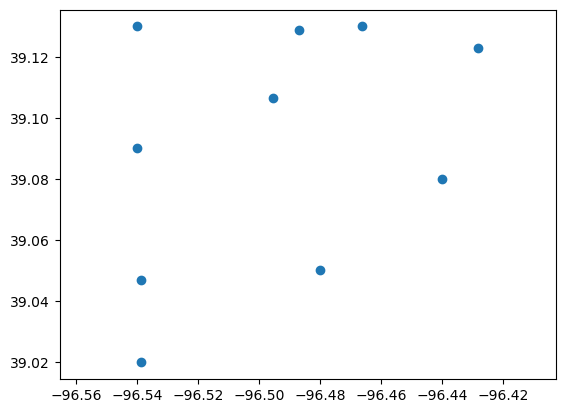

Sampler built with 167567 ignition points.


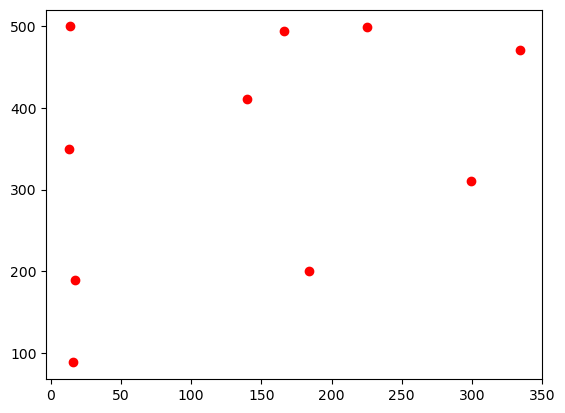

  1%|▏         | 1/72 [00:06<07:52,  6.65s/it]

Failed 0
0344_03155
No fires found for layout 0344_03155
0024_02655


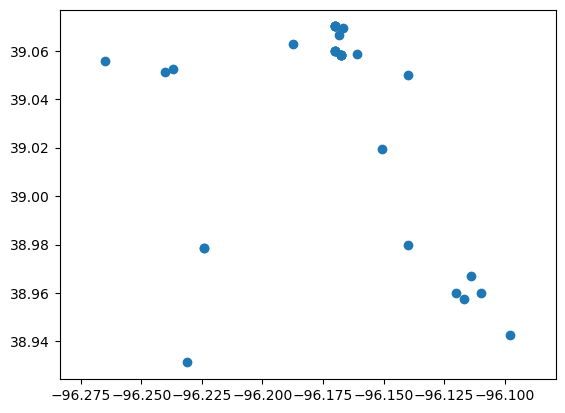

Sampler built with 207530 ignition points.


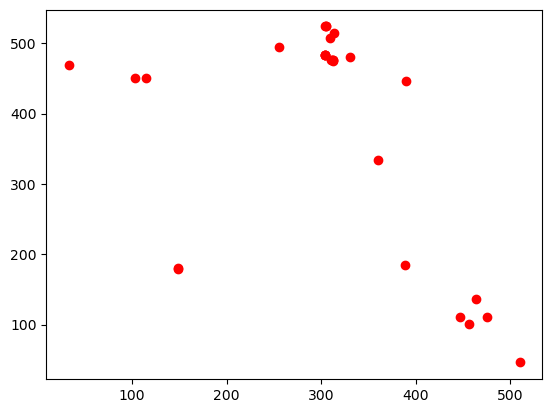

  4%|▍         | 3/72 [00:56<23:21, 20.31s/it]

Failed 3
0106_02165
Layout ./WideDataset/0106_02165/Satellite_Images_Mask/ does not exist


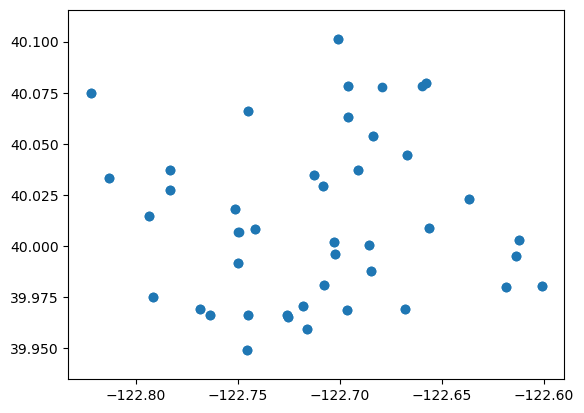

Error processing 0106_00530: No JPG files found in folder: ./WideDataset/0106_02165/Satellite_Image_Mask/0106_00530/
Error processing 0106_00487: No JPG files found in folder: ./WideDataset/0106_02165/Satellite_Image_Mask/0106_00487/
Error processing 0106_00486: No JPG files found in folder: ./WideDataset/0106_02165/Satellite_Image_Mask/0106_00486/
Error processing 0106_00488: No JPG files found in folder: ./WideDataset/0106_02165/Satellite_Image_Mask/0106_00488/
Error processing 0106_01644: No JPG files found in folder: ./WideDataset/0106_02165/Satellite_Image_Mask/0106_01644/
Error processing 0106_01643: No JPG files found in folder: ./WideDataset/0106_02165/Satellite_Image_Mask/0106_01643/
Error processing 0106_00753: No JPG files found in folder: ./WideDataset/0106_02165/Satellite_Image_Mask/0106_00753/
Error processing 0106_00754: No JPG files found in folder: ./WideDataset/0106_02165/Satellite_Image_Mask/0106_00754/
Error processing 0106_00755: No JPG files found in folder: ./Wid

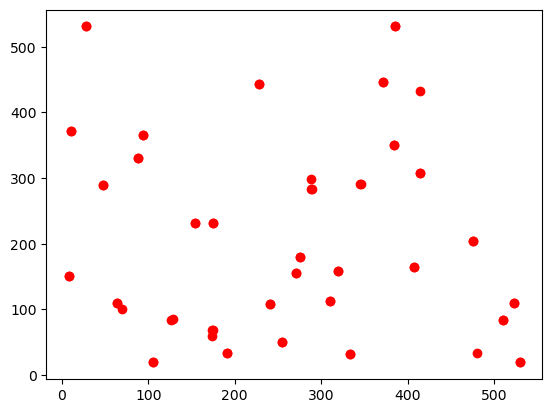

  6%|▌         | 4/72 [01:35<30:15, 26.70s/it]

Failed 15
0092_03189


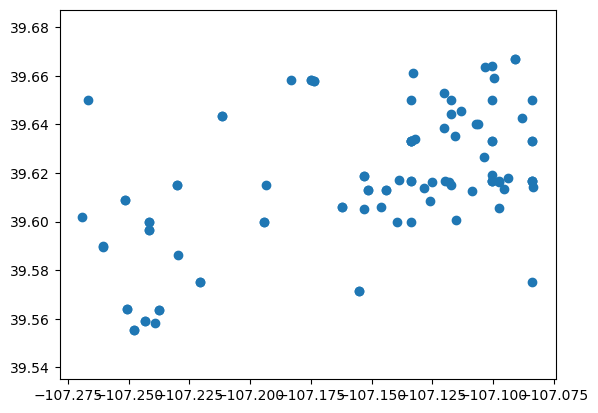

Sampler built with 72368 ignition points.


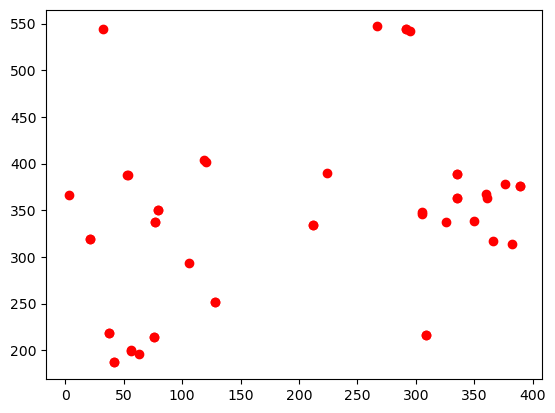

  7%|▋         | 5/72 [02:22<37:14, 33.35s/it]

Failed 53
!! Failed 53 out of 101 for layout 0092_03189 !!
0111_03612
Layout ./WideDataset/0111_03612/Satellite_Images_Mask/ does not exist


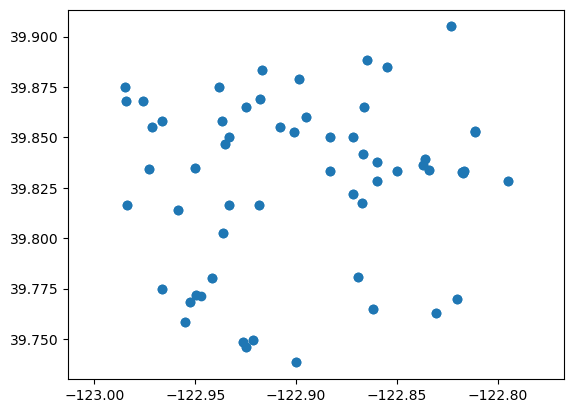

Error processing 0111_02486: No JPG files found in folder: ./WideDataset/0111_03612/Satellite_Image_Mask/0111_02486/
Error processing 0111_02488: No JPG files found in folder: ./WideDataset/0111_03612/Satellite_Image_Mask/0111_02488/
Error processing 0111_01266: No JPG files found in folder: ./WideDataset/0111_03612/Satellite_Image_Mask/0111_01266/
Error processing 0111_01268: No JPG files found in folder: ./WideDataset/0111_03612/Satellite_Image_Mask/0111_01268/
Error processing 0111_02487: No JPG files found in folder: ./WideDataset/0111_03612/Satellite_Image_Mask/0111_02487/
Error processing 0111_01267: No JPG files found in folder: ./WideDataset/0111_03612/Satellite_Image_Mask/0111_01267/
Error processing 0111_00001: No JPG files found in folder: ./WideDataset/0111_03612/Satellite_Image_Mask/0111_00001/
Error processing 0111_00431: No JPG files found in folder: ./WideDataset/0111_03612/Satellite_Image_Mask/0111_00431/
Error processing 0111_01187: No JPG files found in folder: ./Wid

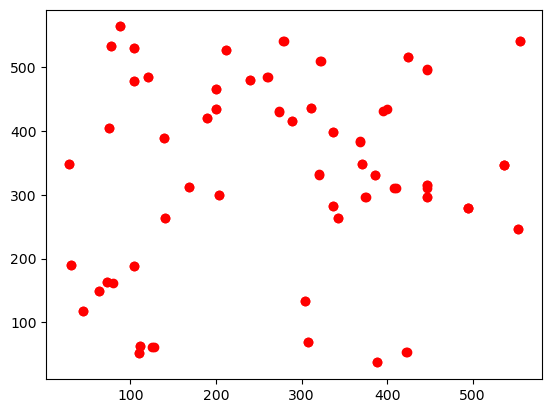

  8%|▊         | 6/72 [03:49<55:34, 50.52s/it]

Failed 9
0023_00995


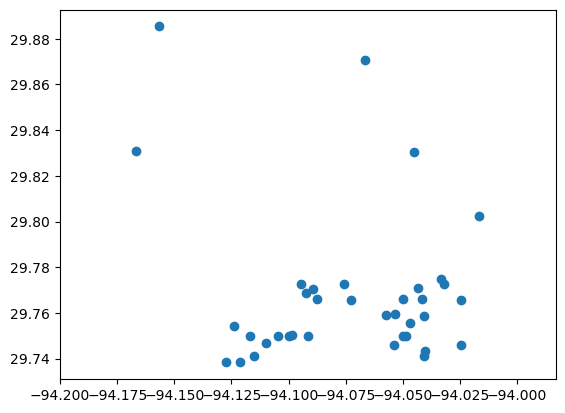

Sampler built with 79841 ignition points.


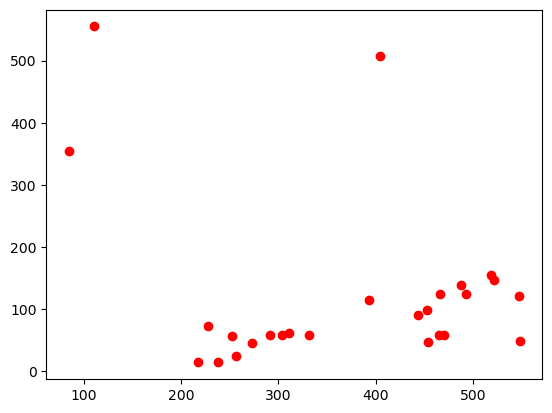

 10%|▉         | 7/72 [04:09<44:21, 40.95s/it]

Failed 11
!! Failed 11 out of 37 for layout 0023_00995 !!
0089_00984


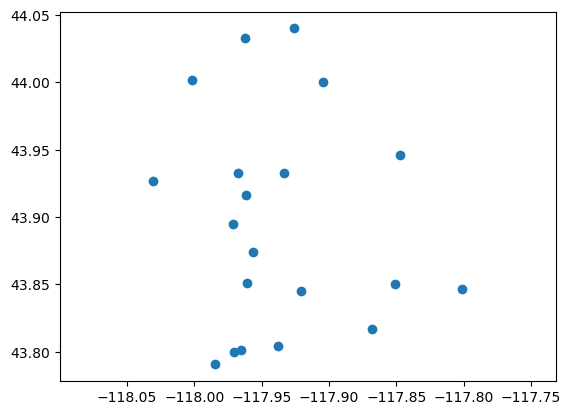

Sampler built with 22261 ignition points.
Scenario 0089_00777 has the wrong size for layout 0089_00984: 583 != 559 or 931 != 479


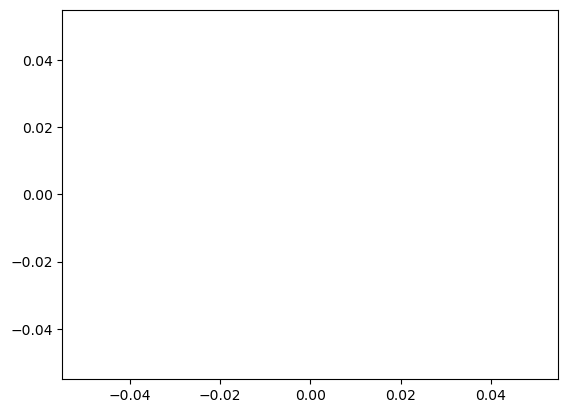

 11%|█         | 8/72 [04:26<35:50, 33.60s/it]

Failed 0
0104_02422
Layout ./WideDataset/0104_02422/Satellite_Images_Mask/ does not exist


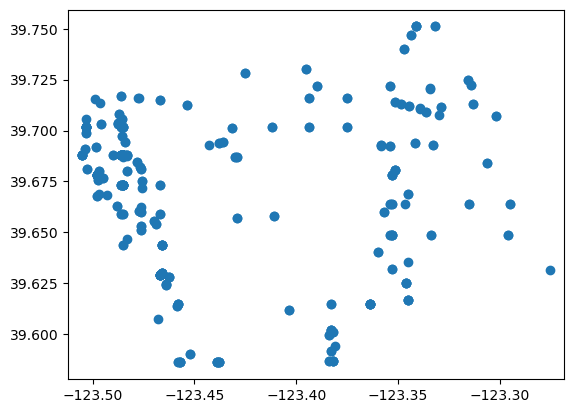

Error processing 0104_00224: No JPG files found in folder: ./WideDataset/0104_02422/Satellite_Image_Mask/0104_00224/
Error processing 0104_00223: No JPG files found in folder: ./WideDataset/0104_02422/Satellite_Image_Mask/0104_00223/
Error processing 0104_00225: No JPG files found in folder: ./WideDataset/0104_02422/Satellite_Image_Mask/0104_00225/
Error processing 0104_01125: No JPG files found in folder: ./WideDataset/0104_02422/Satellite_Image_Mask/0104_01125/
Error processing 0104_01124: No JPG files found in folder: ./WideDataset/0104_02422/Satellite_Image_Mask/0104_01124/
Error processing 0104_01123: No JPG files found in folder: ./WideDataset/0104_02422/Satellite_Image_Mask/0104_01123/
Error processing 0104_02085: No JPG files found in folder: ./WideDataset/0104_02422/Satellite_Image_Mask/0104_02085/
Error processing 0104_00124: No JPG files found in folder: ./WideDataset/0104_02422/Satellite_Image_Mask/0104_00124/
Error processing 0104_02084: No JPG files found in folder: ./Wid

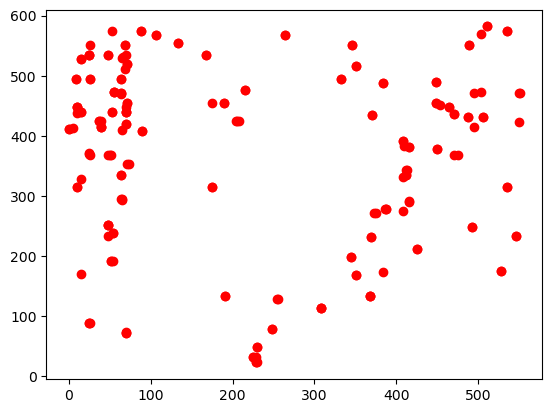

 12%|█▎        | 9/72 [05:04<36:33, 34.82s/it]

Failed 152
!! Failed 152 out of 356 for layout 0104_02422 !!
0041_02386


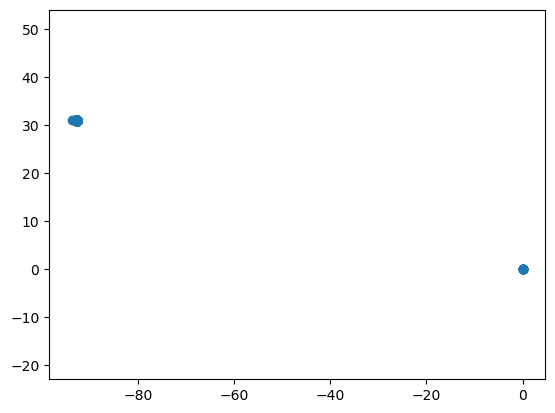

Sampler built with 30010 ignition points.


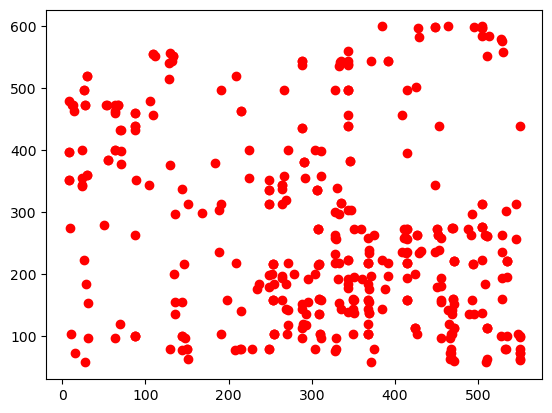

 14%|█▍        | 10/72 [05:56<41:37, 40.29s/it]

Failed 545
!! Failed 545 out of 942 for layout 0041_02386 !!
0016_03070


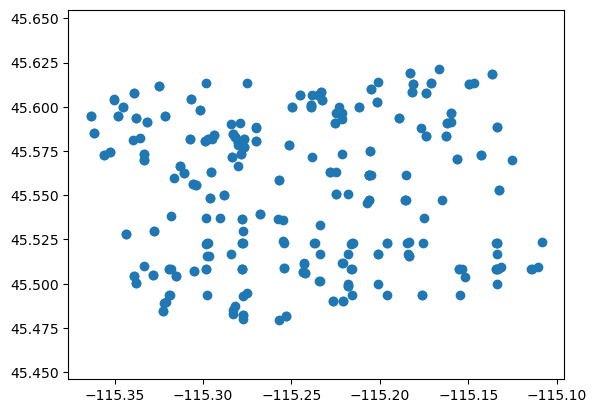

Sampler built with 82185 ignition points.


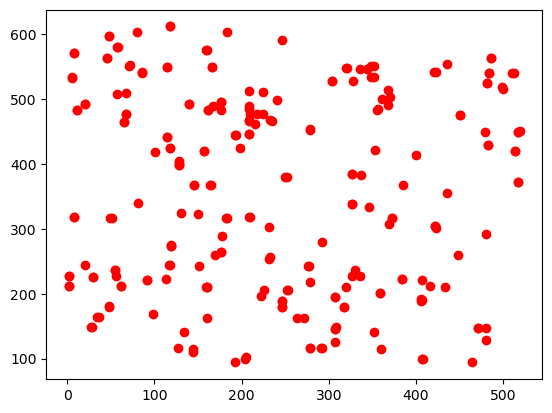

 15%|█▌        | 11/72 [07:20<54:19, 53.43s/it]

Failed 53
0270_02277


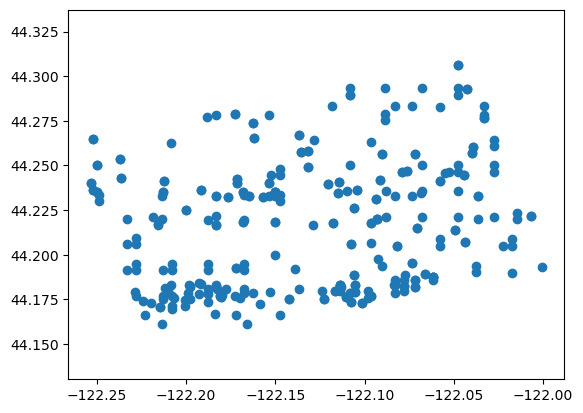

Sampler built with 50236 ignition points.


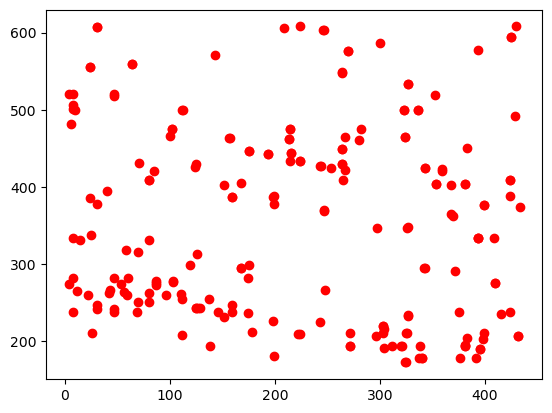

 17%|█▋        | 12/72 [08:19<55:08, 55.15s/it]

Failed 102
!! Failed 102 out of 317 for layout 0270_02277 !!
0105_03054
Layout ./WideDataset/0105_03054/Satellite_Images_Mask/ does not exist


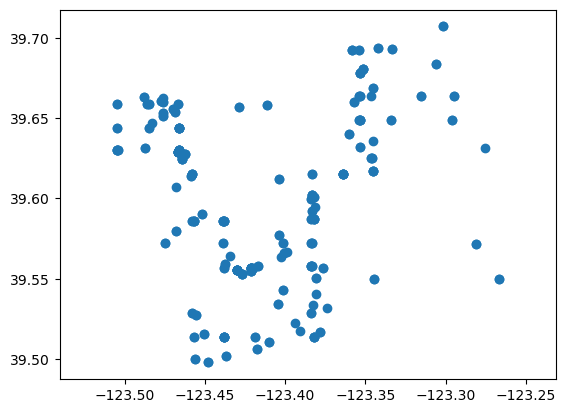

Error processing 0105_00515: No JPG files found in folder: ./WideDataset/0105_03054/Satellite_Image_Mask/0105_00515/
Error processing 0105_00988: No JPG files found in folder: ./WideDataset/0105_03054/Satellite_Image_Mask/0105_00988/
Error processing 0105_00989: No JPG files found in folder: ./WideDataset/0105_03054/Satellite_Image_Mask/0105_00989/
Error processing 0105_00514: No JPG files found in folder: ./WideDataset/0105_03054/Satellite_Image_Mask/0105_00514/
Error processing 0105_00987: No JPG files found in folder: ./WideDataset/0105_03054/Satellite_Image_Mask/0105_00987/
Error processing 0105_02694: No JPG files found in folder: ./WideDataset/0105_03054/Satellite_Image_Mask/0105_02694/
Error processing 0105_02693: No JPG files found in folder: ./WideDataset/0105_03054/Satellite_Image_Mask/0105_02693/
Error processing 0105_01841: No JPG files found in folder: ./WideDataset/0105_03054/Satellite_Image_Mask/0105_01841/
Error processing 0105_02692: No JPG files found in folder: ./Wid

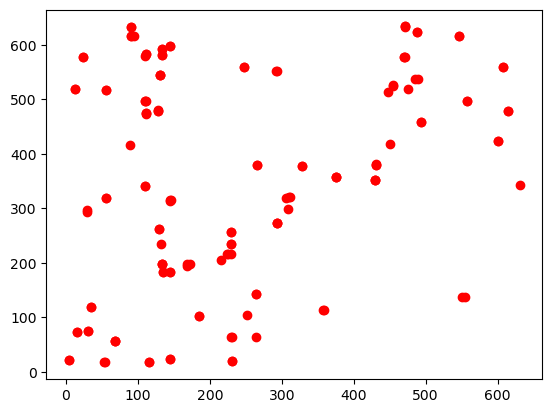

 18%|█▊        | 13/72 [09:29<58:38, 59.63s/it]

Failed 140
!! Failed 140 out of 286 for layout 0105_03054 !!
0259_02663


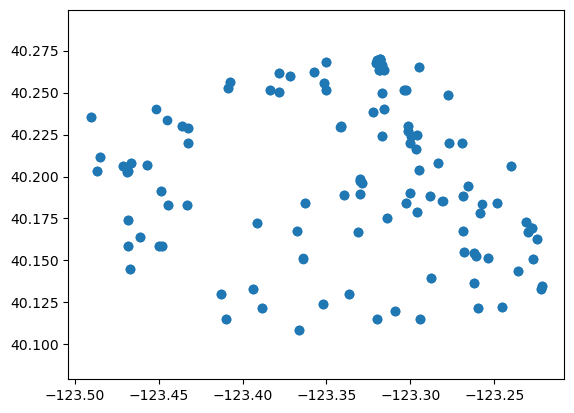

Sampler built with 37736 ignition points.


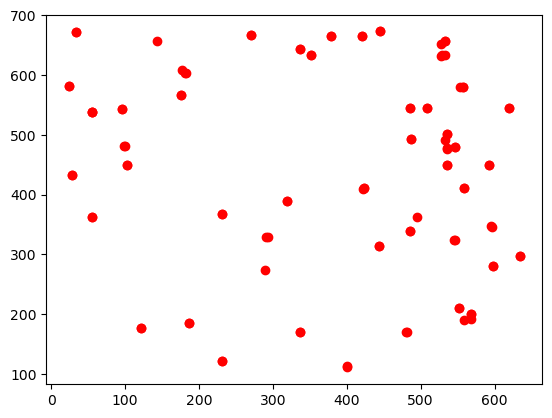

 19%|█▉        | 14/72 [10:18<54:30, 56.39s/it]

Failed 113
!! Failed 113 out of 219 for layout 0259_02663 !!
0037_01578


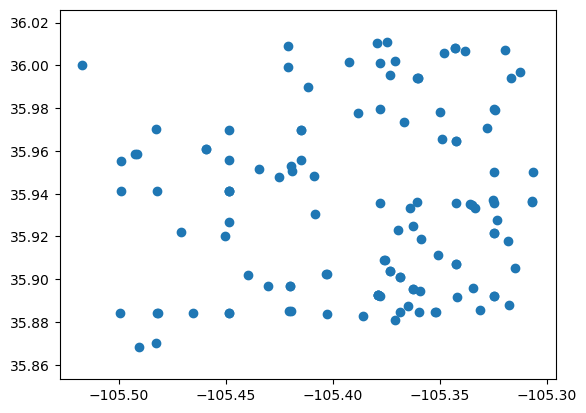

Error processing 0037_00990: No JPG files found in folder: ./WideDataset/0037_01578/Satellite_Images_Mask/0037_00990/
Error processing 0037_00989: No JPG files found in folder: ./WideDataset/0037_01578/Satellite_Images_Mask/0037_00989/
Error processing 0037_00277: No JPG files found in folder: ./WideDataset/0037_01578/Satellite_Images_Mask/0037_00277/
Sampler built with 41686 ignition points.


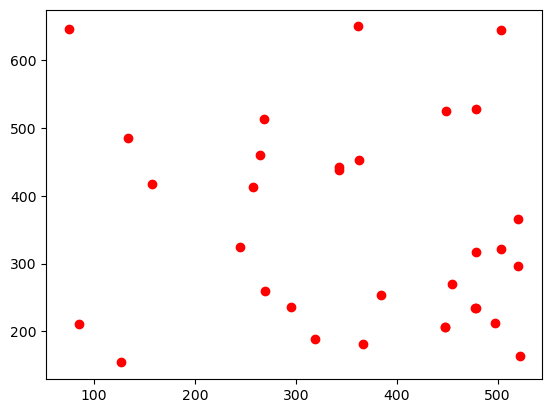

 21%|██        | 15/72 [10:53<47:19, 49.82s/it]

Failed 91
!! Failed 91 out of 123 for layout 0037_01578 !!
0250_02864


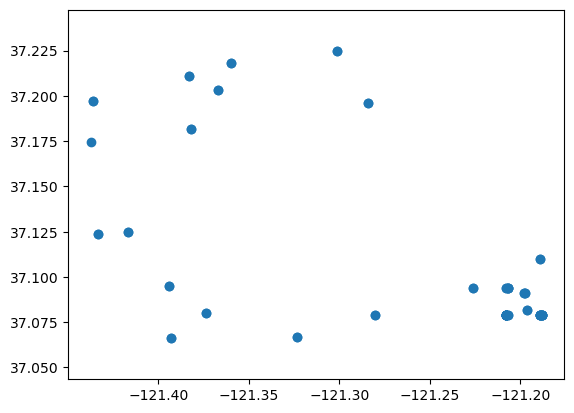

Sampler built with 67691 ignition points.


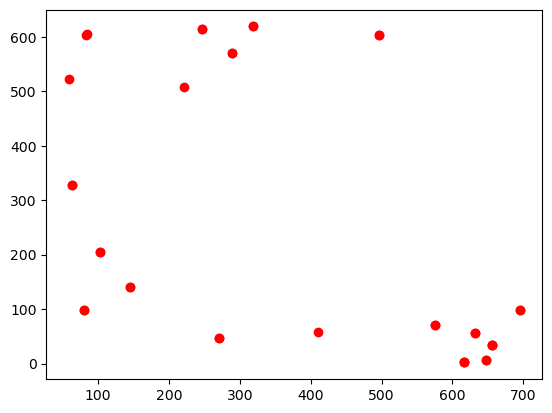

 22%|██▏       | 16/72 [12:02<51:57, 55.67s/it]

Failed 36
!! Failed 36 out of 73 for layout 0250_02864 !!
0252_02927


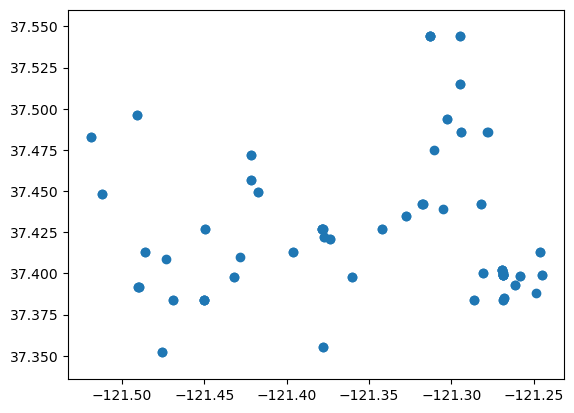

Sampler built with 74218 ignition points.


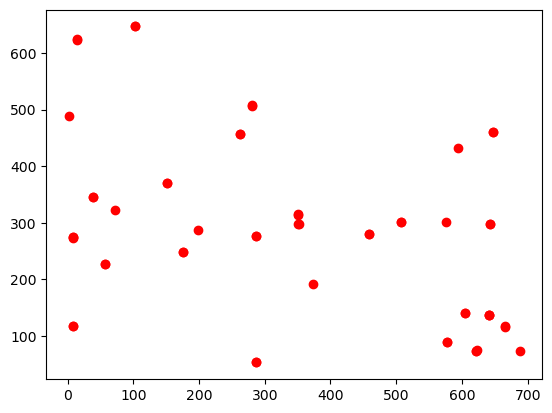

 24%|██▎       | 17/72 [12:55<50:23, 54.97s/it]

Failed 47
!! Failed 47 out of 103 for layout 0252_02927 !!
0324_02925


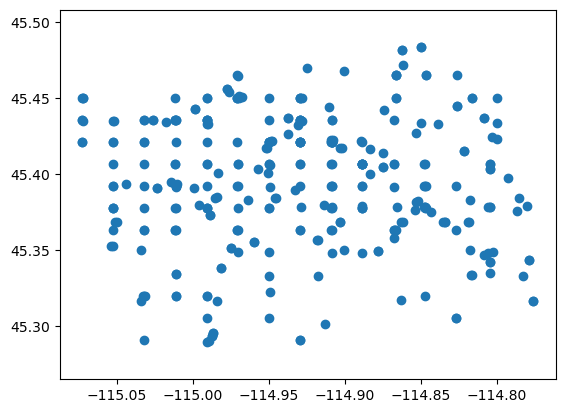

Error processing 0324_00919: No JPG files found in folder: ./WideDataset/0324_02925/Satellite_Images_Mask/0324_00919/
Error processing 0324_00917: No JPG files found in folder: ./WideDataset/0324_02925/Satellite_Images_Mask/0324_00917/
Error processing 0324_00918: No JPG files found in folder: ./WideDataset/0324_02925/Satellite_Images_Mask/0324_00918/
Sampler built with 80276 ignition points.


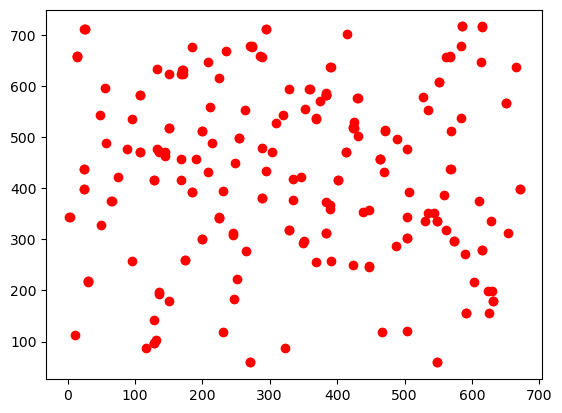

 25%|██▌       | 18/72 [13:54<50:37, 56.25s/it]

Failed 120
!! Failed 120 out of 330 for layout 0324_02925 !!
0249_02843


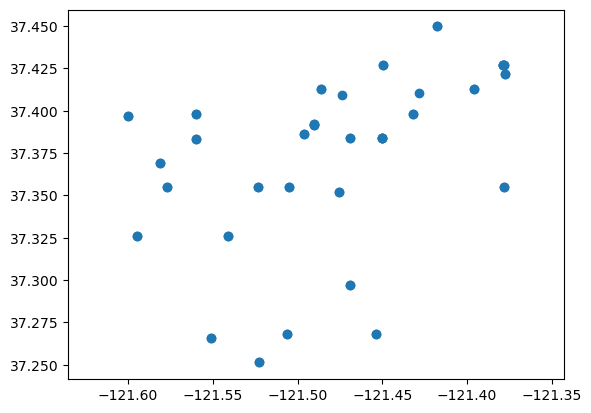

Sampler built with 71212 ignition points.


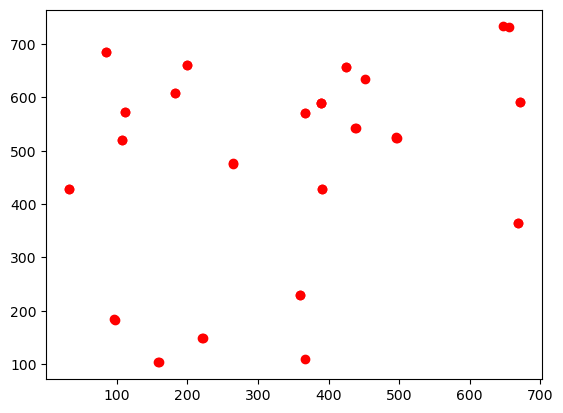

 26%|██▋       | 19/72 [14:57<51:15, 58.03s/it]

Failed 20
!! Failed 20 out of 64 for layout 0249_02843 !!
0004_01191


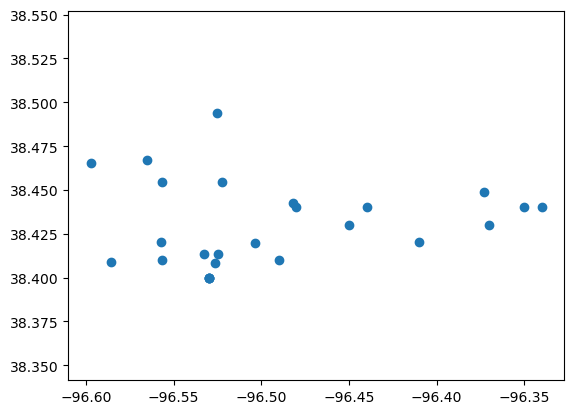

Sampler built with 134452 ignition points.


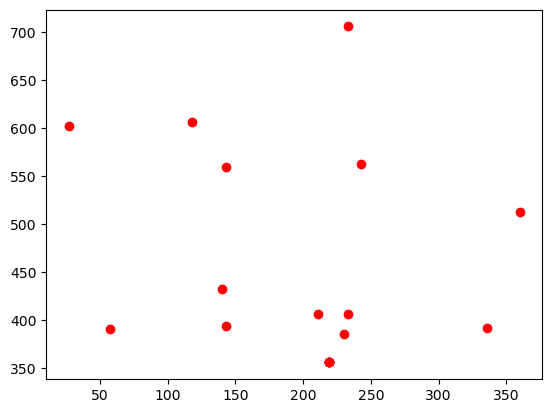

 28%|██▊       | 20/72 [15:07<37:54, 43.75s/it]

Failed 9
!! Failed 9 out of 26 for layout 0004_01191 !!
0243_02722
Layout ./WideDataset/0243_02722/Satellite_Images_Mask/ does not exist


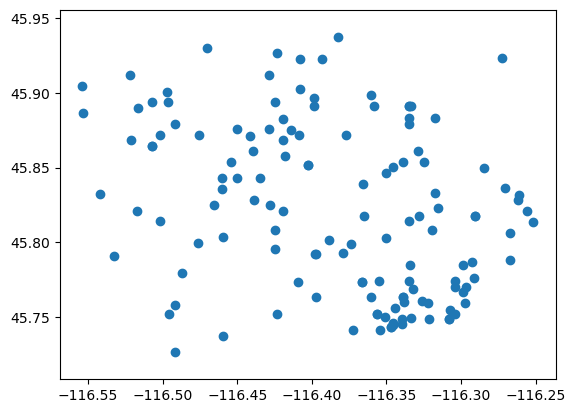

Sampler built with 60899 ignition points.


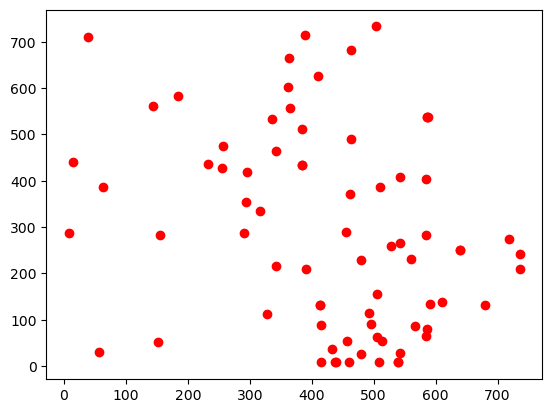

 29%|██▉       | 21/72 [16:10<42:03, 49.48s/it]

Failed 60
!! Failed 60 out of 135 for layout 0243_02722 !!
0251_02843


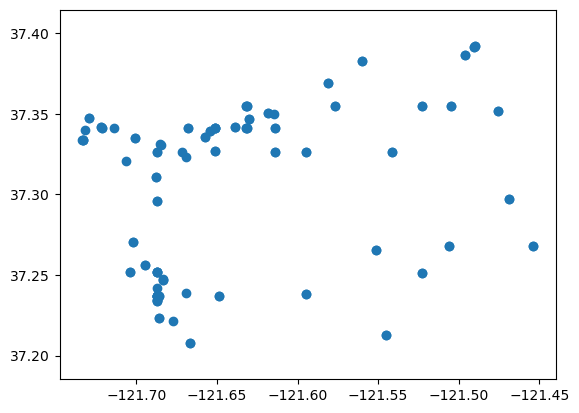

Sampler built with 65322 ignition points.


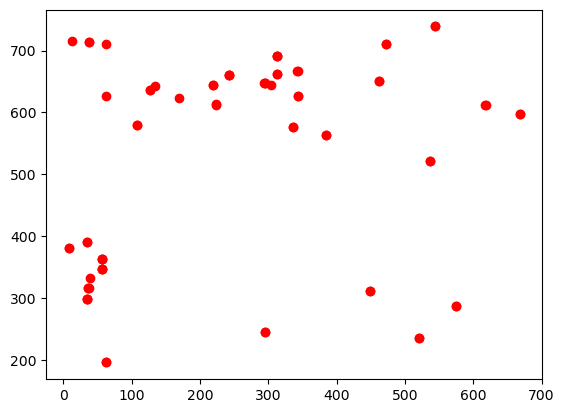

 31%|███       | 22/72 [17:05<42:40, 51.21s/it]

Failed 52
!! Failed 52 out of 126 for layout 0251_02843 !!
0019_01316


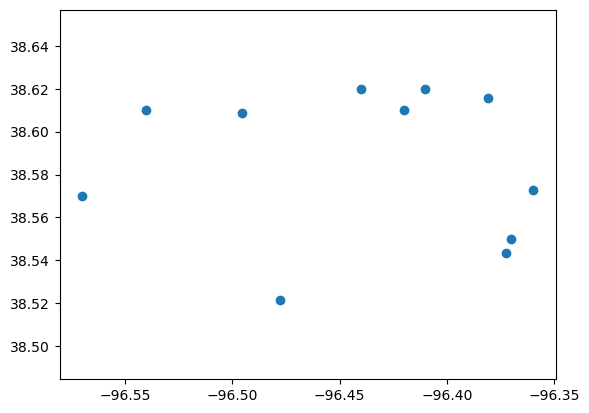

Sampler built with 133355 ignition points.


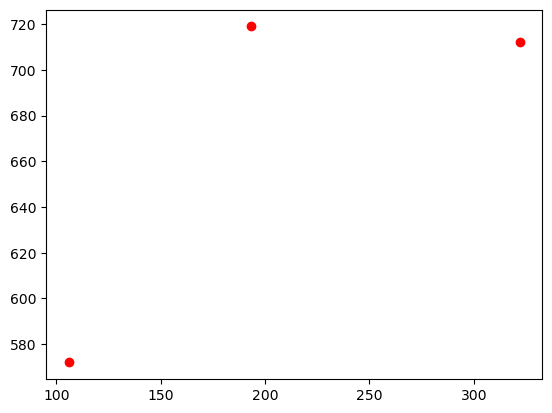

 32%|███▏      | 23/72 [17:27<34:42, 42.50s/it]

Failed 8
!! Failed 8 out of 11 for layout 0019_01316 !!
0013_01466


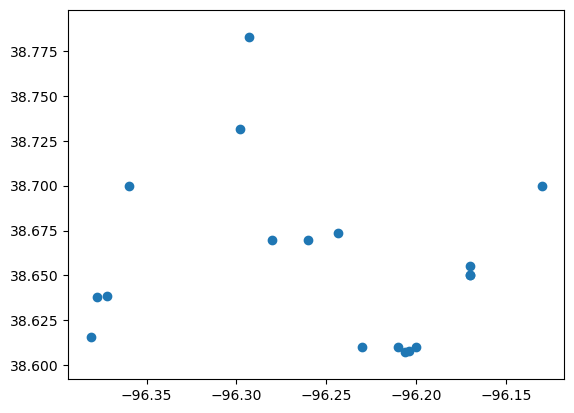

Sampler built with 143276 ignition points.
Scenario 0013_00258 has the wrong size for layout 0013_01466: 776 != 472 or 816 != 491


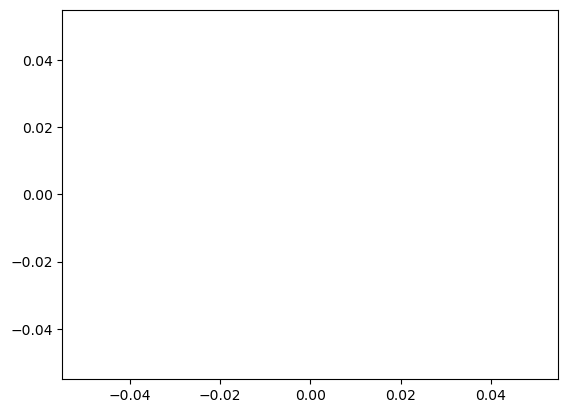

 33%|███▎      | 24/72 [17:49<28:59, 36.23s/it]

Failed 0
0012_02094


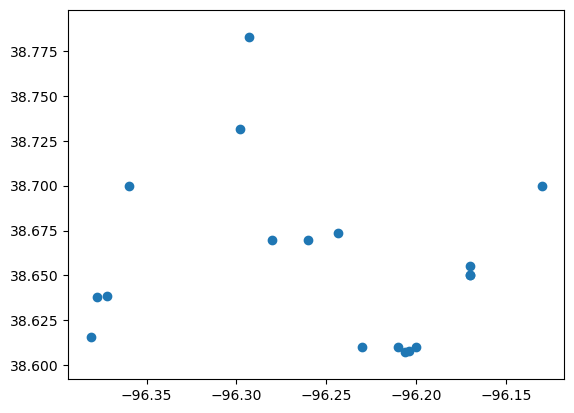

Sampler built with 216358 ignition points.
Scenario 0012_00907 has the wrong size for layout 0012_02094: 776 != 539 or 816 != 580


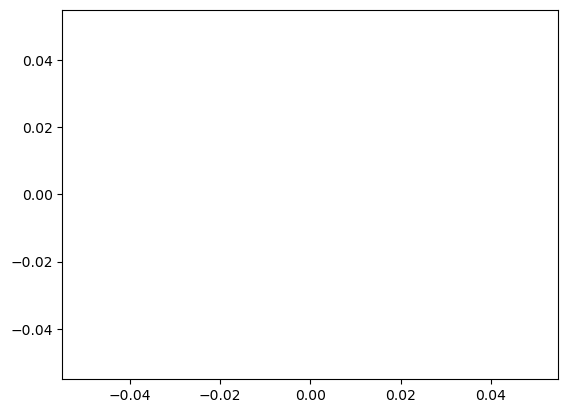

 35%|███▍      | 25/72 [18:34<30:21, 38.75s/it]

Failed 0
0248_01962


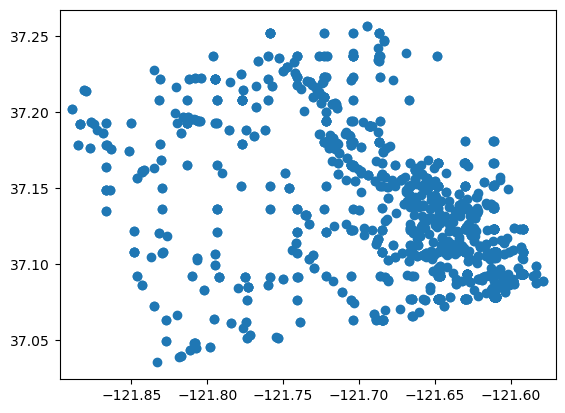

Sampler built with 44039 ignition points.


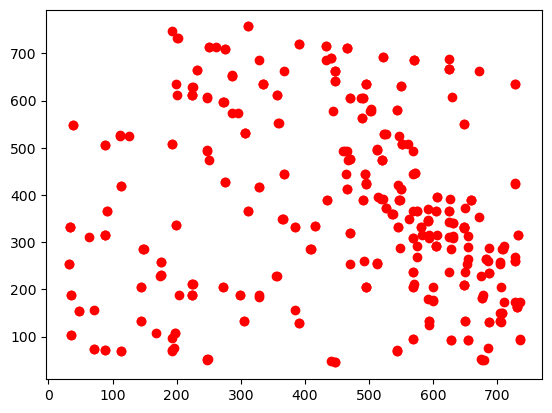

 36%|███▌      | 26/72 [19:21<31:45, 41.43s/it]

Failed 1075
!! Failed 1075 out of 1450 for layout 0248_01962 !!
0067_03550


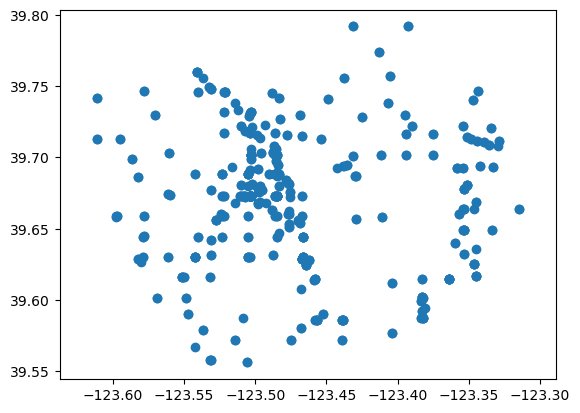

Error processing 0067_00248: No JPG files found in folder: ./WideDataset/0067_03550/Satellite_Images_Mask/0067_00248/
Error processing 0067_01507: No JPG files found in folder: ./WideDataset/0067_03550/Satellite_Images_Mask/0067_01507/
Error processing 0067_01735: No JPG files found in folder: ./WideDataset/0067_03550/Satellite_Images_Mask/0067_01735/
Error processing 0067_03266: No JPG files found in folder: ./WideDataset/0067_03550/Satellite_Images_Mask/0067_03266/
Error processing 0067_02186: No JPG files found in folder: ./WideDataset/0067_03550/Satellite_Images_Mask/0067_02186/
Error processing 0067_00246: No JPG files found in folder: ./WideDataset/0067_03550/Satellite_Images_Mask/0067_00246/
Error processing 0067_00247: No JPG files found in folder: ./WideDataset/0067_03550/Satellite_Images_Mask/0067_00247/
Error processing 0067_01705: No JPG files found in folder: ./WideDataset/0067_03550/Satellite_Images_Mask/0067_01705/
Error processing 0067_02187: No JPG files found in folde

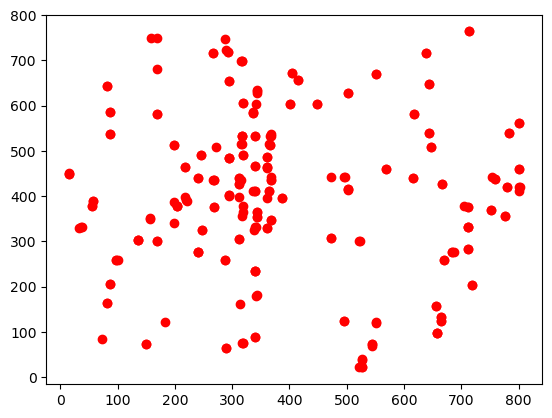

 38%|███▊      | 27/72 [20:46<40:53, 54.52s/it]

Failed 311
!! Failed 311 out of 567 for layout 0067_03550 !!
0246_00984


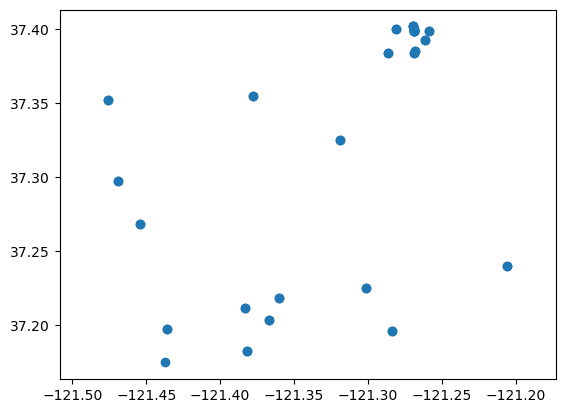

Sampler built with 24709 ignition points.


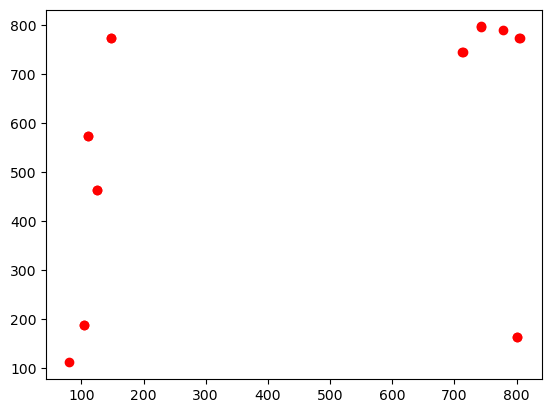

 39%|███▉      | 28/72 [21:12<33:35, 45.81s/it]

Failed 33
!! Failed 33 out of 51 for layout 0246_00984 !!
0084_02609


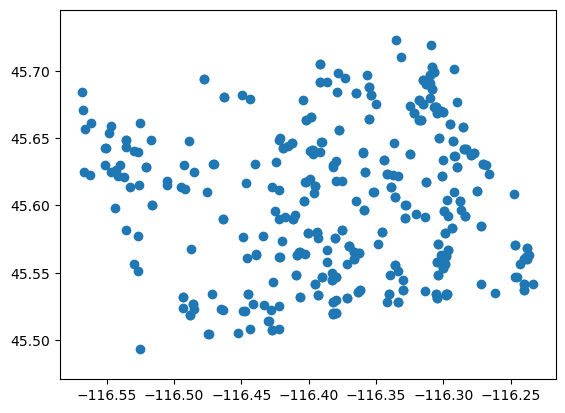

Sampler built with 57858 ignition points.


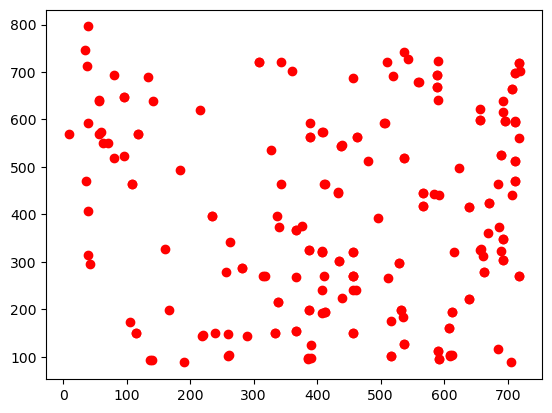

 40%|████      | 29/72 [22:24<38:33, 53.80s/it]

Failed 185
!! Failed 185 out of 393 for layout 0084_02609 !!
0247_03453


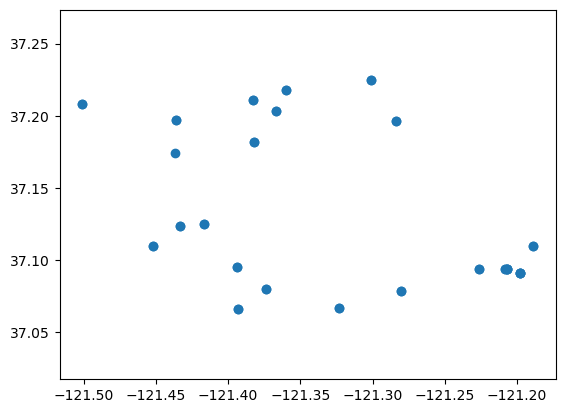

Sampler built with 82847 ignition points.


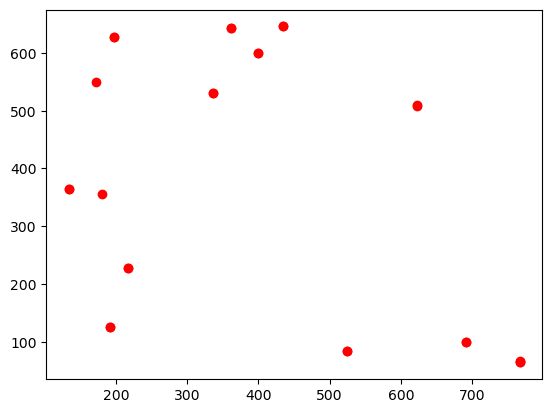

 42%|████▏     | 30/72 [23:45<43:16, 61.82s/it]

Failed 20
!! Failed 20 out of 47 for layout 0247_03453 !!
0065_03061


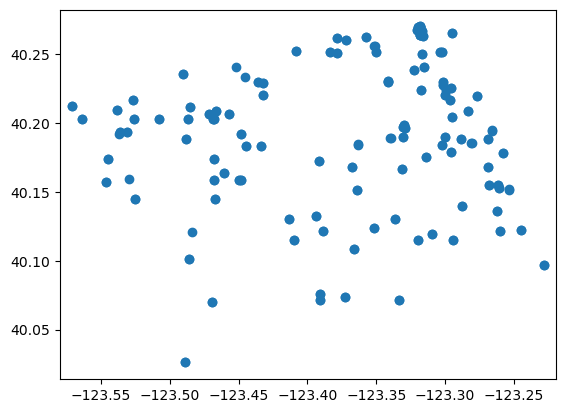

Error processing 0065_00278: No JPG files found in folder: ./WideDataset/0065_03061/Satellite_Images_Mask/0065_00278/
Error processing 0065_01530: No JPG files found in folder: ./WideDataset/0065_03061/Satellite_Images_Mask/0065_01530/
Error processing 0065_00473: No JPG files found in folder: ./WideDataset/0065_03061/Satellite_Images_Mask/0065_00473/
Error processing 0065_00222: No JPG files found in folder: ./WideDataset/0065_03061/Satellite_Images_Mask/0065_00222/
Error processing 0065_01531: No JPG files found in folder: ./WideDataset/0065_03061/Satellite_Images_Mask/0065_01531/
Error processing 0065_00279: No JPG files found in folder: ./WideDataset/0065_03061/Satellite_Images_Mask/0065_00279/
Error processing 0065_00277: No JPG files found in folder: ./WideDataset/0065_03061/Satellite_Images_Mask/0065_00277/
Error processing 0065_02110: No JPG files found in folder: ./WideDataset/0065_03061/Satellite_Images_Mask/0065_02110/
Error processing 0065_00472: No JPG files found in folde

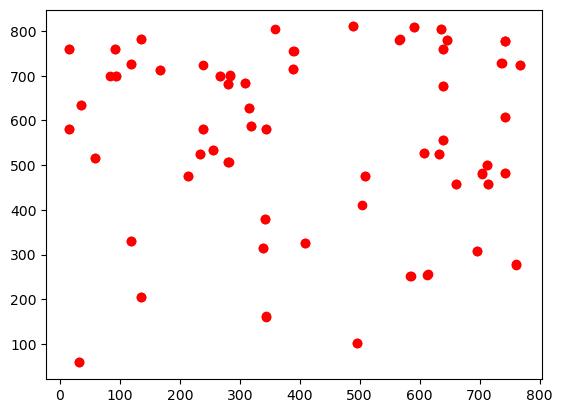

 43%|████▎     | 31/72 [25:08<46:38, 68.27s/it]

Failed 115
!! Failed 115 out of 231 for layout 0065_03061 !!
0064_02717
Layout ./WideDataset/0064_02717/Satellite_Images_Mask/ does not exist


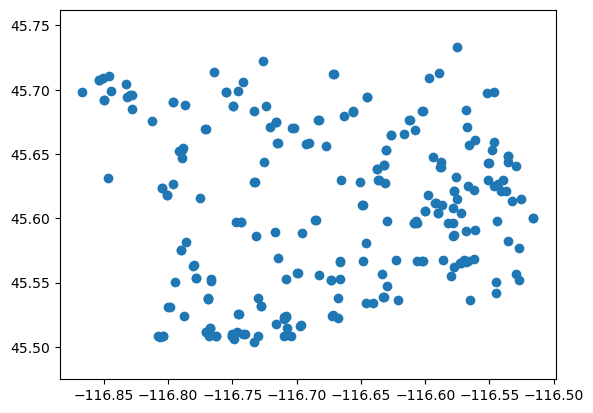

Sampler built with 47947 ignition points.


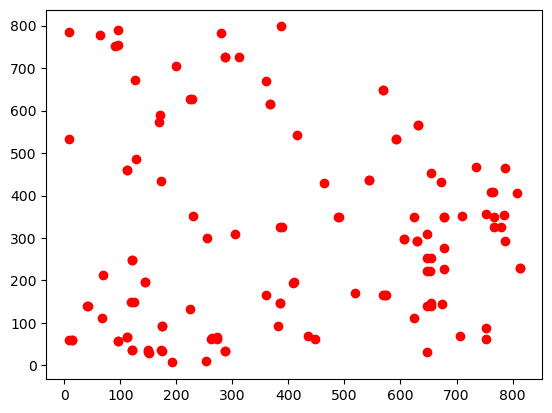

 44%|████▍     | 32/72 [26:03<42:54, 64.35s/it]

Failed 117
!! Failed 117 out of 244 for layout 0064_02717 !!
0066_03773


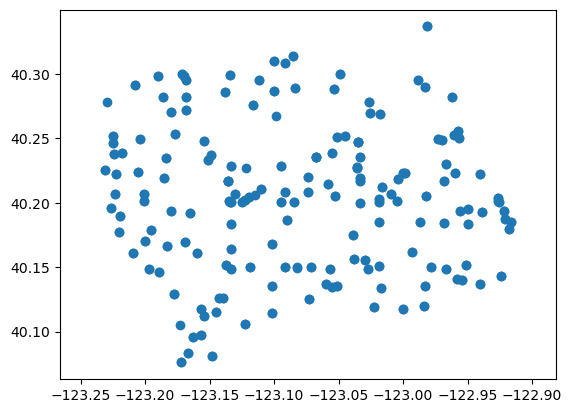

Error processing 0066_01057: No JPG files found in folder: ./WideDataset/0066_03773/Satellite_Images_Mask/0066_01057/
Error processing 0066_00388: No JPG files found in folder: ./WideDataset/0066_03773/Satellite_Images_Mask/0066_00388/
Error processing 0066_01262: No JPG files found in folder: ./WideDataset/0066_03773/Satellite_Images_Mask/0066_01262/
Error processing 0066_01606: No JPG files found in folder: ./WideDataset/0066_03773/Satellite_Images_Mask/0066_01606/
Error processing 0066_03731: No JPG files found in folder: ./WideDataset/0066_03773/Satellite_Images_Mask/0066_03731/
Error processing 0066_01608: No JPG files found in folder: ./WideDataset/0066_03773/Satellite_Images_Mask/0066_01608/
Error processing 0066_03595: No JPG files found in folder: ./WideDataset/0066_03773/Satellite_Images_Mask/0066_03595/
Error processing 0066_02229: No JPG files found in folder: ./WideDataset/0066_03773/Satellite_Images_Mask/0066_02229/
Error processing 0066_03730: No JPG files found in folde

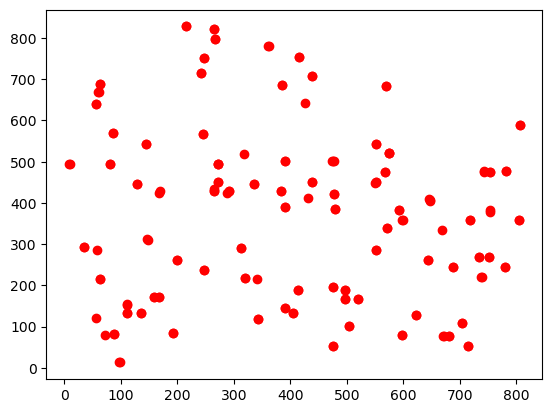

 46%|████▌     | 33/72 [27:22<44:40, 68.74s/it]

Failed 156
!! Failed 156 out of 341 for layout 0066_03773 !!
0069_03539


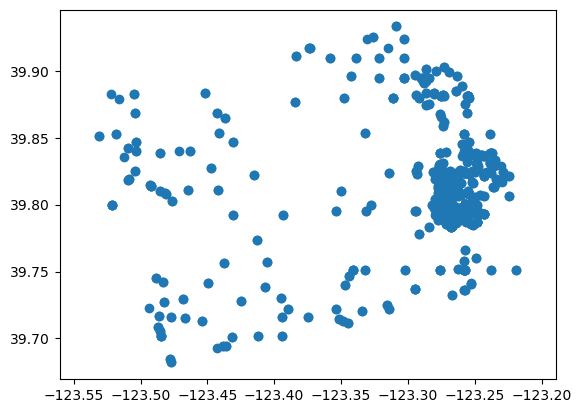

Error processing 0069_00250: No JPG files found in folder: ./WideDataset/0069_03539/Satellite_Images_Mask/0069_00250/
Error processing 0069_01186: No JPG files found in folder: ./WideDataset/0069_03539/Satellite_Images_Mask/0069_01186/
Error processing 0069_02951: No JPG files found in folder: ./WideDataset/0069_03539/Satellite_Images_Mask/0069_02951/
Error processing 0069_03074: No JPG files found in folder: ./WideDataset/0069_03539/Satellite_Images_Mask/0069_03074/
Error processing 0069_03080: No JPG files found in folder: ./WideDataset/0069_03539/Satellite_Images_Mask/0069_03080/
Error processing 0069_02131: No JPG files found in folder: ./WideDataset/0069_03539/Satellite_Images_Mask/0069_02131/
Error processing 0069_02950: No JPG files found in folder: ./WideDataset/0069_03539/Satellite_Images_Mask/0069_02950/
Error processing 0069_03081: No JPG files found in folder: ./WideDataset/0069_03539/Satellite_Images_Mask/0069_03081/
Error processing 0069_01346: No JPG files found in folde

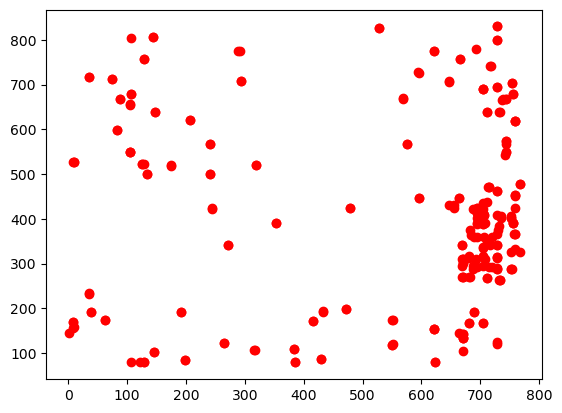

 47%|████▋     | 34/72 [29:12<51:15, 80.93s/it]

Failed 960
!! Failed 960 out of 1225 for layout 0069_03539 !!
0059_02804
Layout ./WideDataset/0059_02804/Satellite_Images_Mask/ does not exist


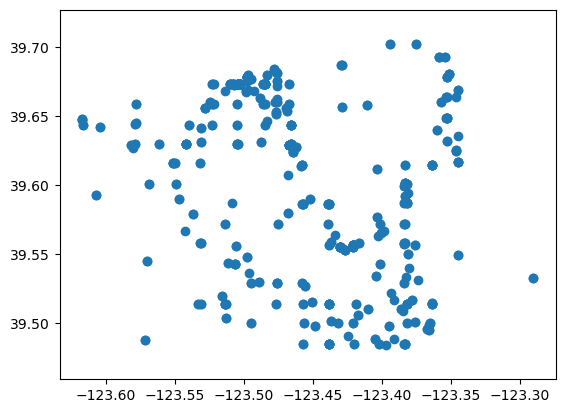

Sampler built with 54394 ignition points.


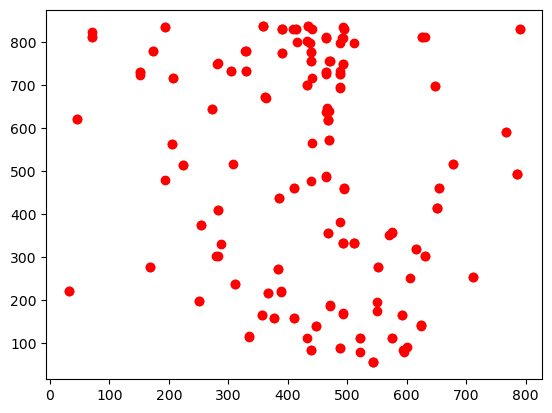

 49%|████▊     | 35/72 [30:18<47:10, 76.50s/it]

Failed 333
!! Failed 333 out of 531 for layout 0059_02804 !!
0102_01733


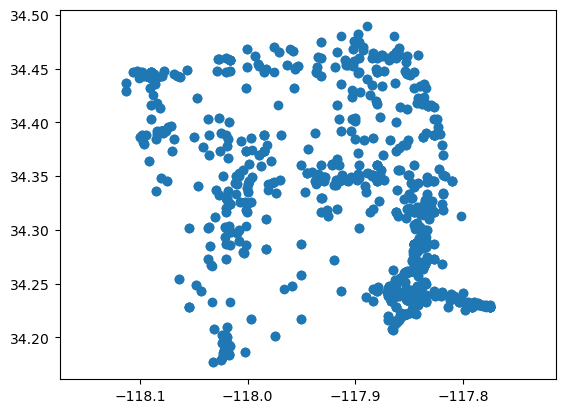

Sampler built with 44473 ignition points.
Scenario 0102_00647 has the wrong size for layout 0102_01733: 846 != 565 or 1046 != 555


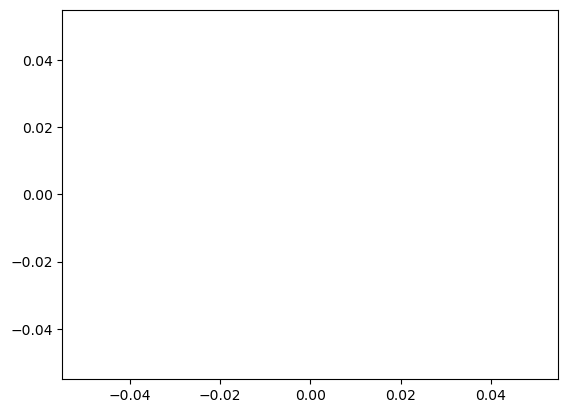

 50%|█████     | 36/72 [30:54<38:41, 64.49s/it]

Failed 0
0103_01810


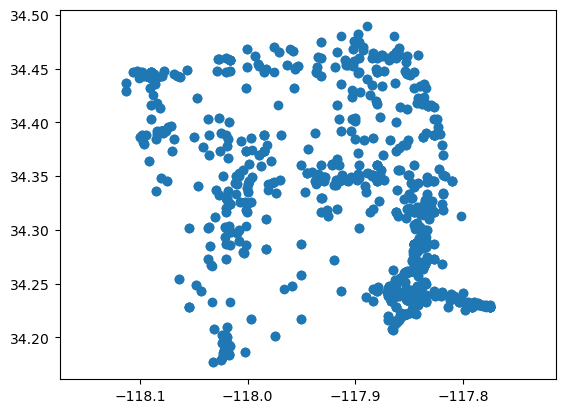

Sampler built with 55126 ignition points.
Scenario 0103_00524 has the wrong size for layout 0103_01810: 846 != 591 or 1046 != 638


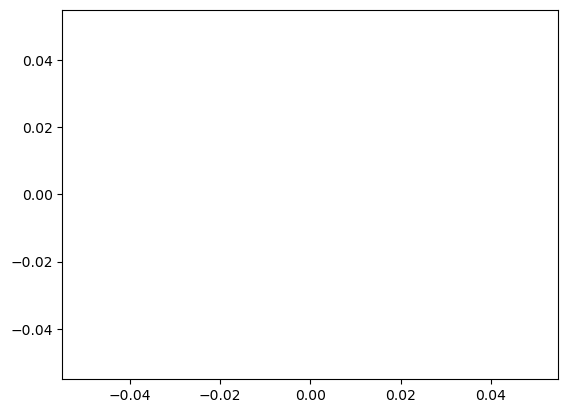

 51%|█████▏    | 37/72 [31:36<33:36, 57.61s/it]

Failed 0
0068_04211


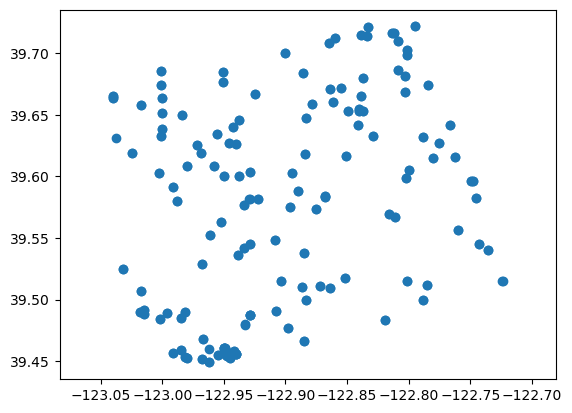

Error processing 0068_01414: No JPG files found in folder: ./WideDataset/0068_04211/Satellite_Images_Mask/0068_01414/
Error processing 0068_03185: No JPG files found in folder: ./WideDataset/0068_04211/Satellite_Images_Mask/0068_03185/
Error processing 0068_04161: No JPG files found in folder: ./WideDataset/0068_04211/Satellite_Images_Mask/0068_04161/
Error processing 0068_03512: No JPG files found in folder: ./WideDataset/0068_04211/Satellite_Images_Mask/0068_03512/
Error processing 0068_00997: No JPG files found in folder: ./WideDataset/0068_04211/Satellite_Images_Mask/0068_00997/
Error processing 0068_01449: No JPG files found in folder: ./WideDataset/0068_04211/Satellite_Images_Mask/0068_01449/
Error processing 0068_00339: No JPG files found in folder: ./WideDataset/0068_04211/Satellite_Images_Mask/0068_00339/
Error processing 0068_03928: No JPG files found in folder: ./WideDataset/0068_04211/Satellite_Images_Mask/0068_03928/
Error processing 0068_01471: No JPG files found in folde

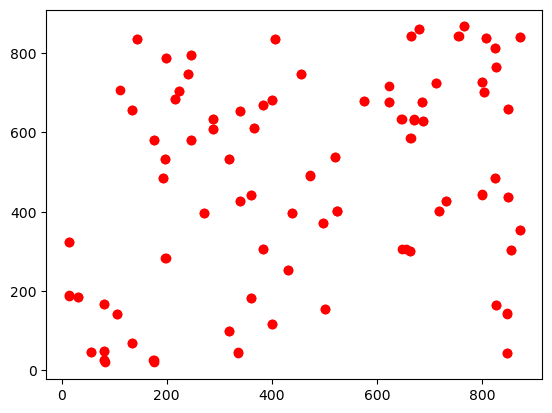

 53%|█████▎    | 38/72 [33:02<37:26, 66.06s/it]

Failed 118
!! Failed 118 out of 278 for layout 0068_04211 !!
0082_03155


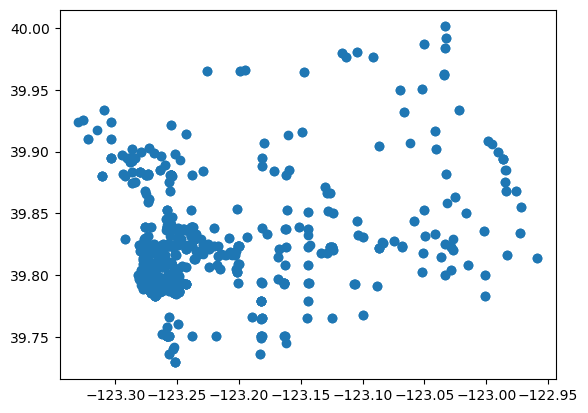

Sampler built with 60983 ignition points.


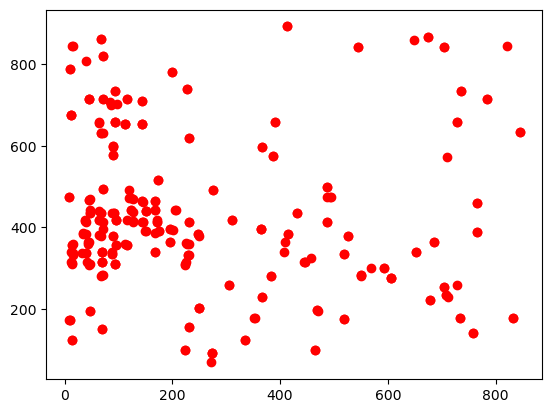

 54%|█████▍    | 39/72 [34:27<39:28, 71.78s/it]

Failed 1047
!! Failed 1047 out of 1346 for layout 0082_03155 !!
0261_02900


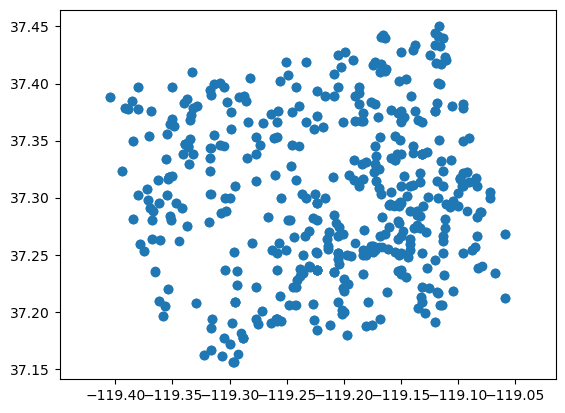

Error processing 0261_02322: No JPG files found in folder: ./WideDataset/0261_02900/Satellite_Images_Mask/0261_02322/
Error processing 0261_02467: No JPG files found in folder: ./WideDataset/0261_02900/Satellite_Images_Mask/0261_02467/
Sampler built with 41960 ignition points.


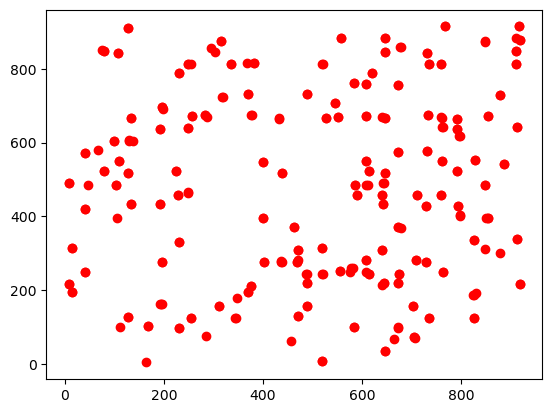

 56%|█████▌    | 40/72 [35:37<38:01, 71.28s/it]

Failed 535
!! Failed 535 out of 846 for layout 0261_02900 !!
0057_03186


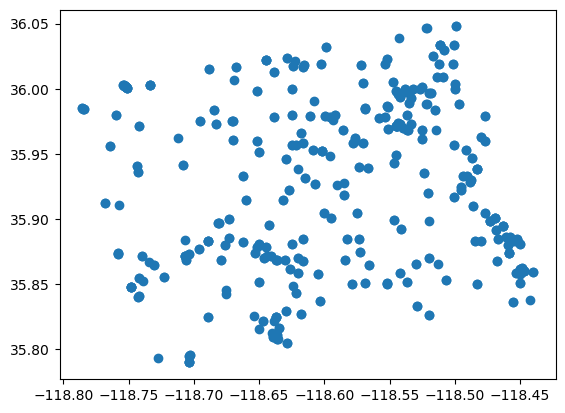

Sampler built with 73611 ignition points.


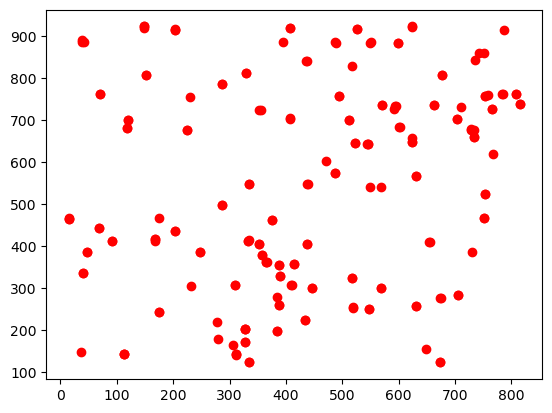

 57%|█████▋    | 41/72 [36:50<37:06, 71.82s/it]

Failed 344
!! Failed 344 out of 544 for layout 0057_03186 !!
0090_00987


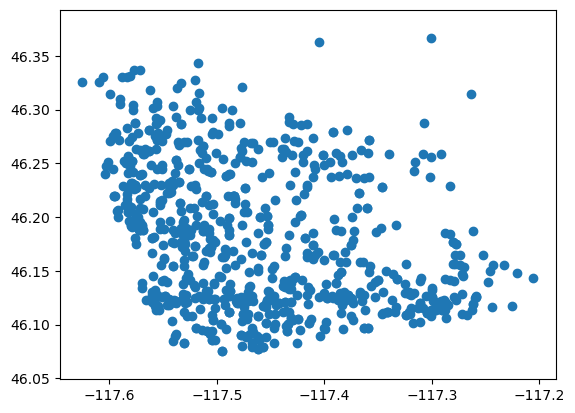

Sampler built with 19427 ignition points.
Scenario 0090_00947 has the wrong size for layout 0090_00987: 931 != 555 or 1009 != 505


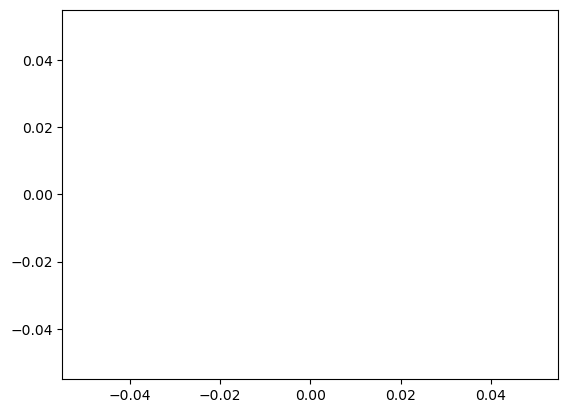

 58%|█████▊    | 42/72 [37:10<28:08, 56.29s/it]

Failed 0
0242_02940
Layout ./WideDataset/0242_02940/Satellite_Images_Mask/ does not exist


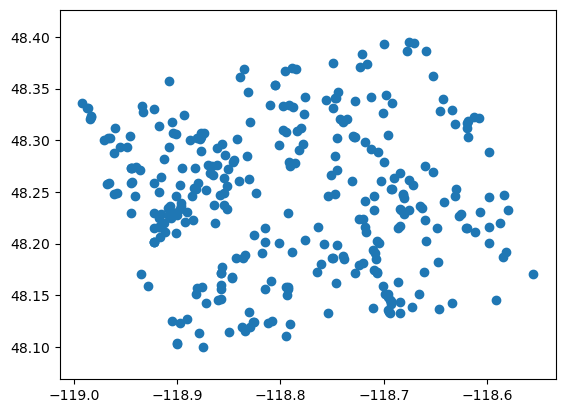

Sampler built with 56151 ignition points.


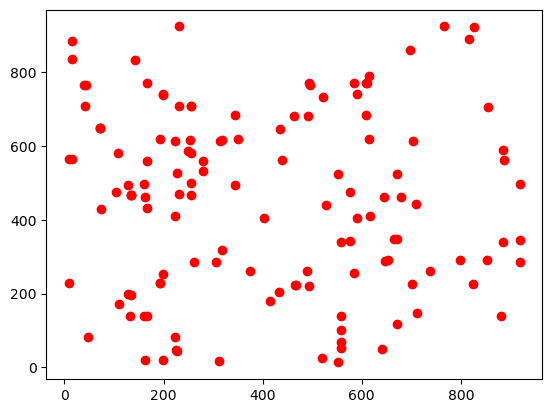

 60%|█████▉    | 43/72 [38:17<28:44, 59.48s/it]

Failed 205
!! Failed 205 out of 336 for layout 0242_02940 !!
0245_03988
Error for layout 0245_03988: No JPG files found in folder: ./WideDataset/0245_03988/Satellite_Images_Mask/0245_03900/
0081_03471


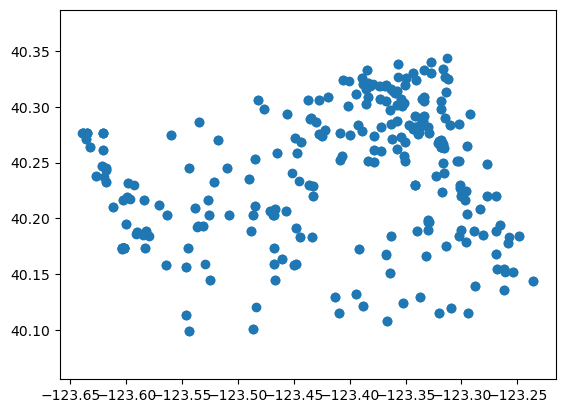

Sampler built with 59480 ignition points.


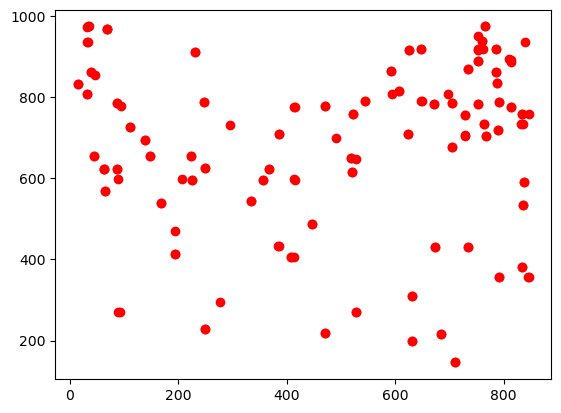

 62%|██████▎   | 45/72 [39:38<22:49, 50.71s/it]

Failed 327
!! Failed 327 out of 503 for layout 0081_03471 !!
0060_03010
Layout ./WideDataset/0060_03010/Satellite_Images_Mask/ does not exist


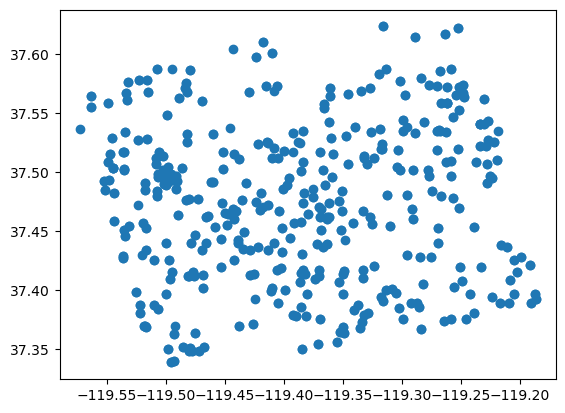

Sampler built with 42128 ignition points.


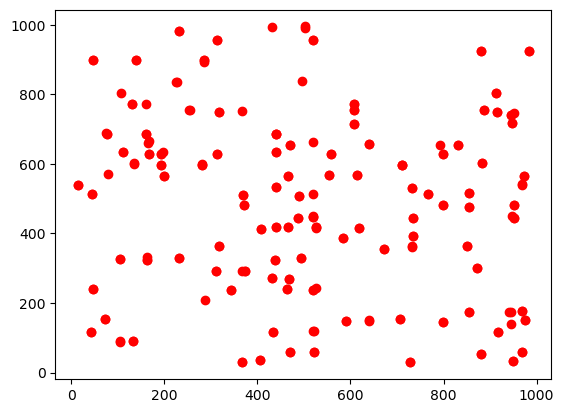

 64%|██████▍   | 46/72 [40:49<24:11, 55.84s/it]

Failed 510
!! Failed 510 out of 754 for layout 0060_03010 !!
0062_03187
Layout ./WideDataset/0062_03187/Satellite_Images_Mask/ does not exist


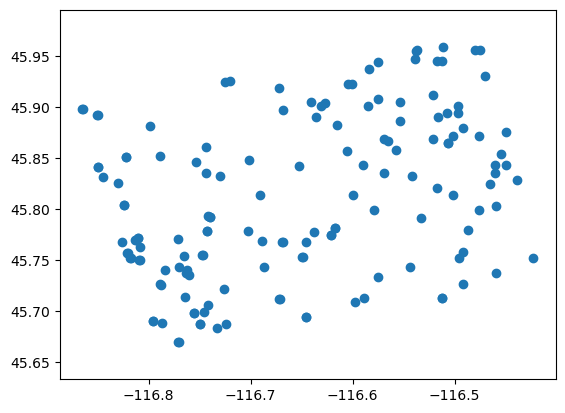

Sampler built with 62755 ignition points.


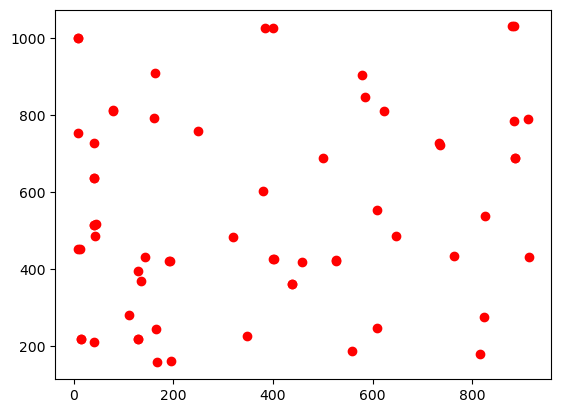

 65%|██████▌   | 47/72 [42:02<25:08, 60.33s/it]

Failed 87
!! Failed 87 out of 151 for layout 0062_03187 !!
0262_03319


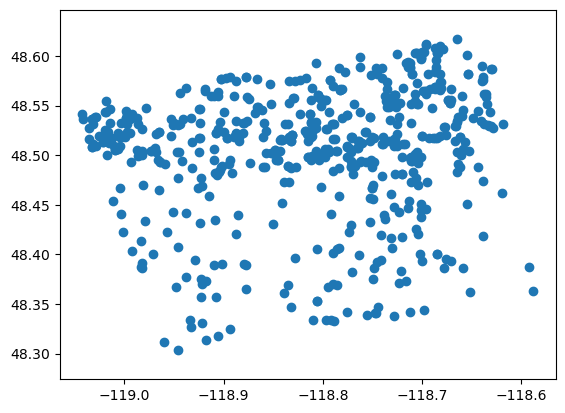

Error processing 0262_01876: No JPG files found in folder: ./WideDataset/0262_03319/Satellite_Images_Mask/0262_01876/
Error processing 0262_01878: No JPG files found in folder: ./WideDataset/0262_03319/Satellite_Images_Mask/0262_01878/
Error processing 0262_01877: No JPG files found in folder: ./WideDataset/0262_03319/Satellite_Images_Mask/0262_01877/
Error processing 0262_02872: No JPG files found in folder: ./WideDataset/0262_03319/Satellite_Images_Mask/0262_02872/
Error processing 0262_02871: No JPG files found in folder: ./WideDataset/0262_03319/Satellite_Images_Mask/0262_02871/
Error processing 0262_02870: No JPG files found in folder: ./WideDataset/0262_03319/Satellite_Images_Mask/0262_02870/
Sampler built with 57460 ignition points.


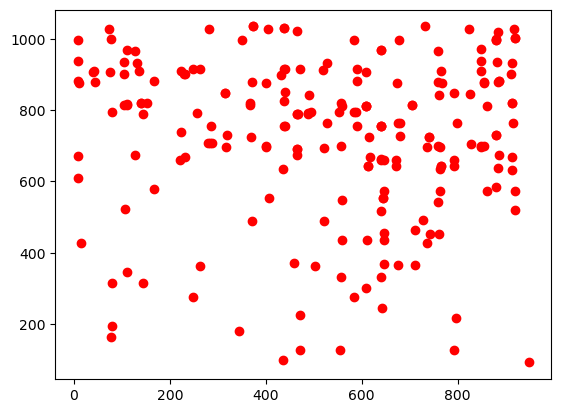

 67%|██████▋   | 48/72 [43:24<26:24, 66.03s/it]

Failed 370
!! Failed 370 out of 591 for layout 0262_03319 !!
0260_03391


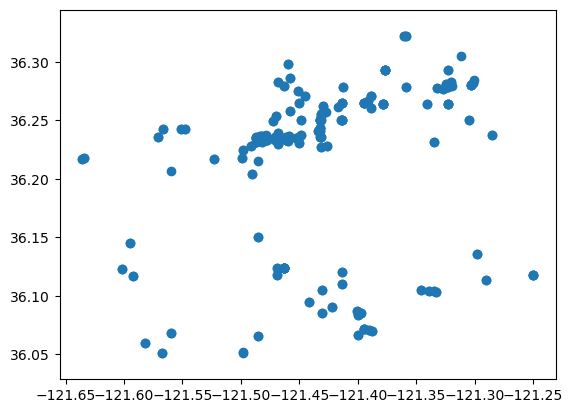

Error processing 0260_02537: No JPG files found in folder: ./WideDataset/0260_03391/Satellite_Images_Mask/0260_02537/
Error processing 0260_02536: No JPG files found in folder: ./WideDataset/0260_03391/Satellite_Images_Mask/0260_02536/
Error processing 0260_02538: No JPG files found in folder: ./WideDataset/0260_03391/Satellite_Images_Mask/0260_02538/
Sampler built with 93639 ignition points.


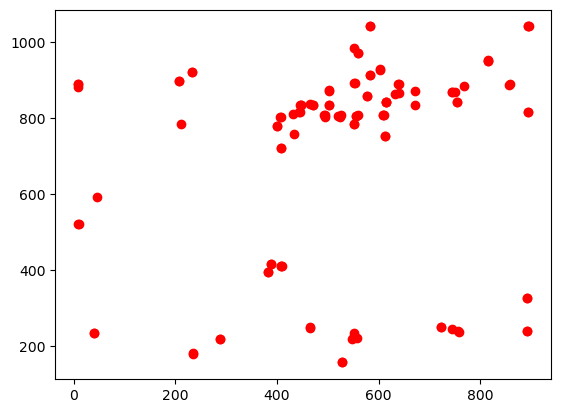

 68%|██████▊   | 49/72 [44:45<26:58, 70.36s/it]

Failed 184
!! Failed 184 out of 299 for layout 0260_03391 !!
0058_03866
Layout ./WideDataset/0058_03866/Satellite_Images_Mask/ does not exist


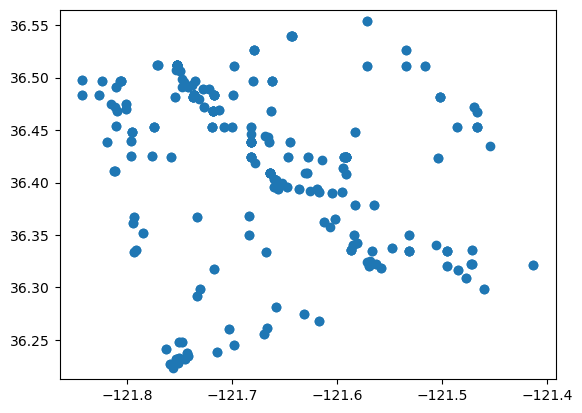

Sampler built with 93521 ignition points.


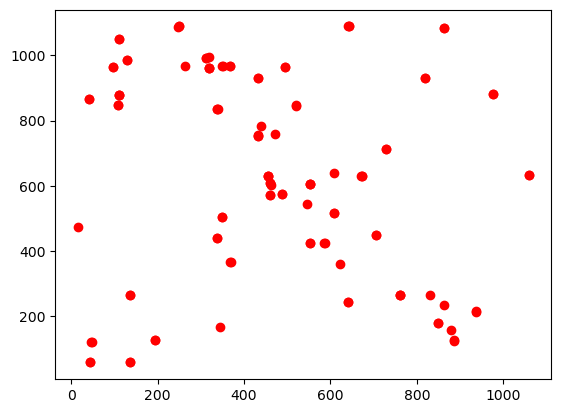

 69%|██████▉   | 50/72 [46:24<28:44, 78.40s/it]

Failed 272
!! Failed 272 out of 385 for layout 0058_03866 !!
0244_03110
Layout ./WideDataset/0244_03110/Satellite_Images_Mask/ does not exist


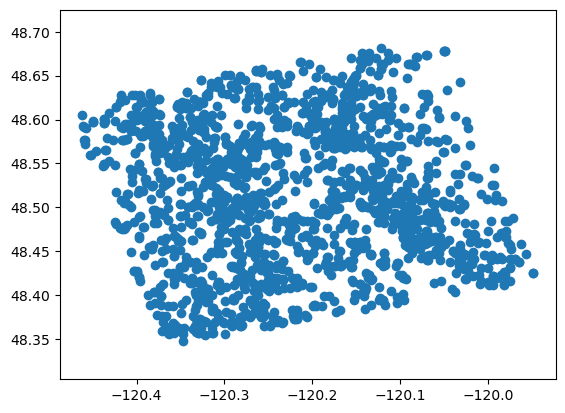

Sampler built with 65437 ignition points.


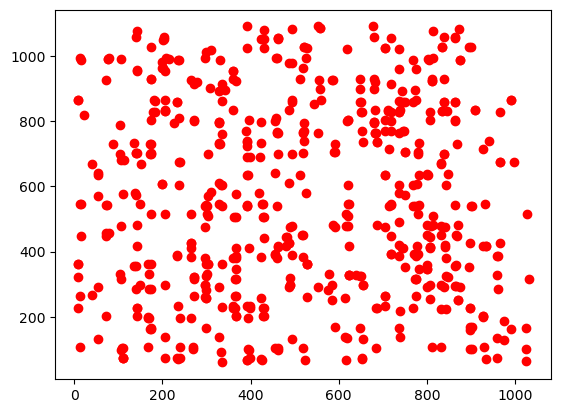

 71%|███████   | 51/72 [47:57<28:55, 82.66s/it]

Failed 1358
!! Failed 1358 out of 1960 for layout 0244_03110 !!
0094_01688


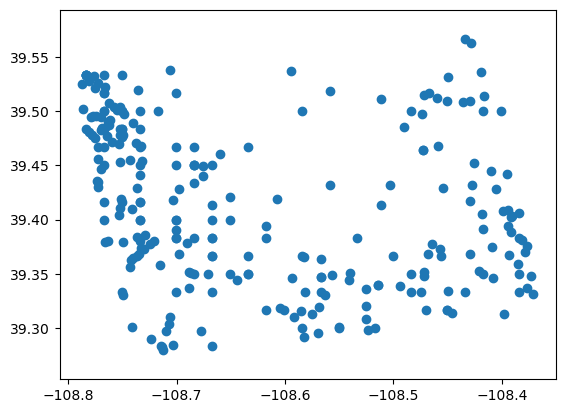

Sampler built with 40067 ignition points.
Scenario 0094_00038 has the wrong size for layout 0094_01688: 1102 != 494 or 977 != 534


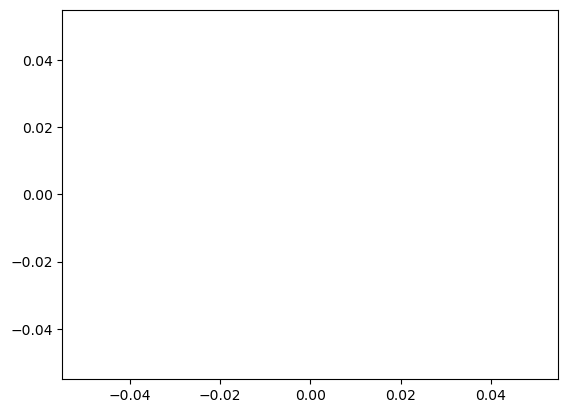

 72%|███████▏  | 52/72 [48:30<22:44, 68.23s/it]

Failed 0
0095_01726


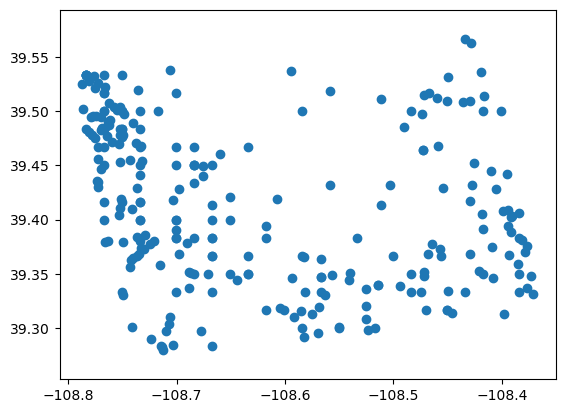

Sampler built with 36114 ignition points.
Scenario out210_2_ArrivalTime has the wrong size for layout 0095_01726: 1102 != 558 or 977 != 487


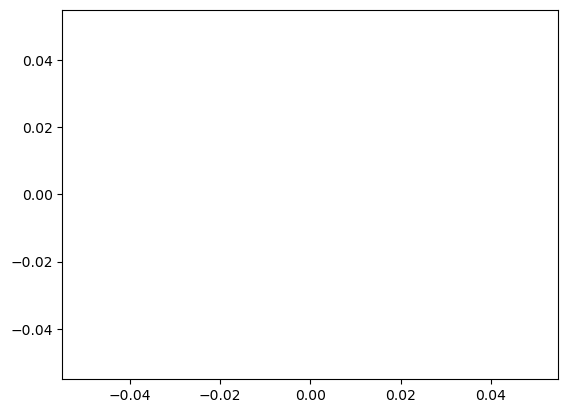

 74%|███████▎  | 53/72 [48:57<17:45, 56.08s/it]

Failed 0
0093_01748


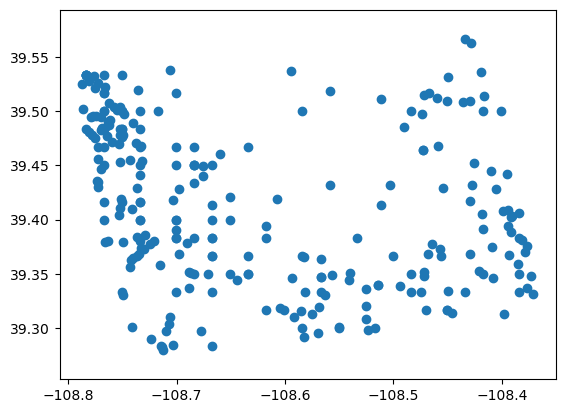

Sampler built with 42163 ignition points.
Scenario 0093_01168 has the wrong size for layout 0093_01748: 1102 != 492 or 977 != 514


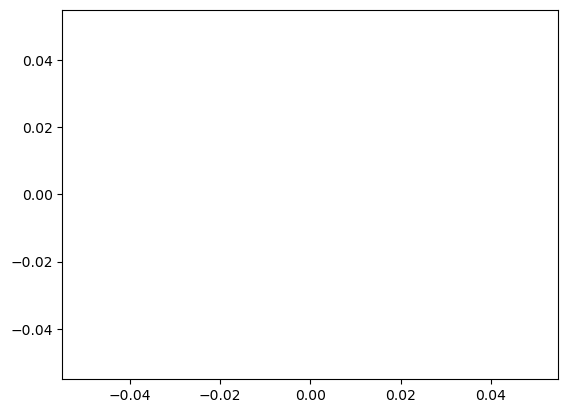

 75%|███████▌  | 54/72 [49:34<15:07, 50.41s/it]

Failed 0
0083_02892


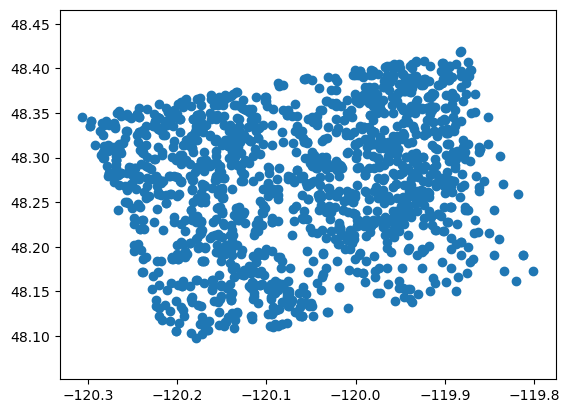

Error processing 0083_02892: No JPG files found in folder: ./WideDataset/0083_02892/Satellite_Images_Mask/0083_02892/
Error processing 0083_02166: No JPG files found in folder: ./WideDataset/0083_02892/Satellite_Images_Mask/0083_02166/
Error processing 0083_02474: No JPG files found in folder: ./WideDataset/0083_02892/Satellite_Images_Mask/0083_02474/
Error processing 0083_02473: No JPG files found in folder: ./WideDataset/0083_02892/Satellite_Images_Mask/0083_02473/
Error processing 0083_00038: No JPG files found in folder: ./WideDataset/0083_02892/Satellite_Images_Mask/0083_00038/
Error processing 0083_02165: No JPG files found in folder: ./WideDataset/0083_02892/Satellite_Images_Mask/0083_02165/
Error processing 0083_00037: No JPG files found in folder: ./WideDataset/0083_02892/Satellite_Images_Mask/0083_00037/
Error processing 0083_00039: No JPG files found in folder: ./WideDataset/0083_02892/Satellite_Images_Mask/0083_00039/
Sampler built with 62177 ignition points.


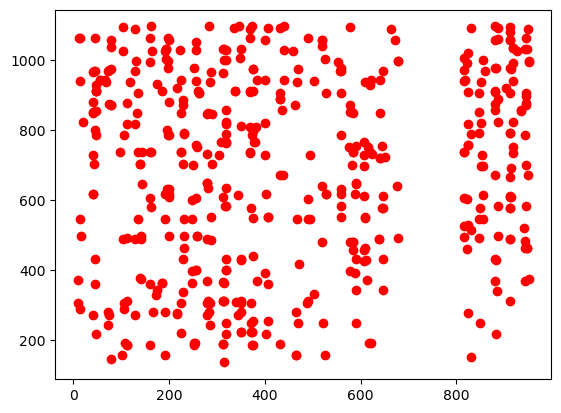

 76%|███████▋  | 55/72 [51:09<18:02, 63.68s/it]

Failed 1025
!! Failed 1025 out of 1518 for layout 0083_02892 !!
0021_01232


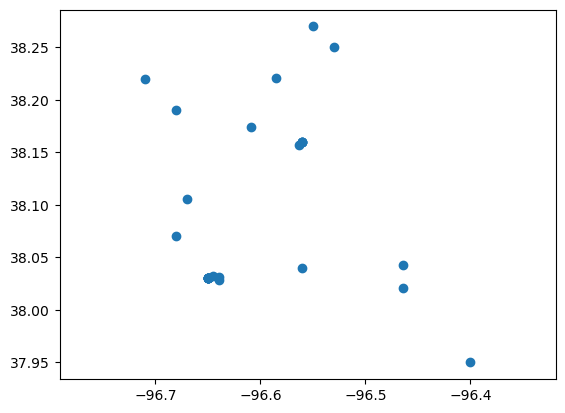

Error processing 0021_00124: No JPG files found in folder: ./WideDataset/0021_01232/Satellite_Images_Mask/0021_00124/
Error processing 0021_00123: No JPG files found in folder: ./WideDataset/0021_01232/Satellite_Images_Mask/0021_00123/
Error processing 0021_00125: No JPG files found in folder: ./WideDataset/0021_01232/Satellite_Images_Mask/0021_00125/
Error processing 0021_00655: No JPG files found in folder: ./WideDataset/0021_01232/Satellite_Images_Mask/0021_00655/
Error processing 0021_00035: No JPG files found in folder: ./WideDataset/0021_01232/Satellite_Images_Mask/0021_00035/
Error processing 0021_00092: No JPG files found in folder: ./WideDataset/0021_01232/Satellite_Images_Mask/0021_00092/
Error processing 0021_00830: No JPG files found in folder: ./WideDataset/0021_01232/Satellite_Images_Mask/0021_00830/
Error processing 0021_00654: No JPG files found in folder: ./WideDataset/0021_01232/Satellite_Images_Mask/0021_00654/
Error processing 0021_00653: No JPG files found in folde

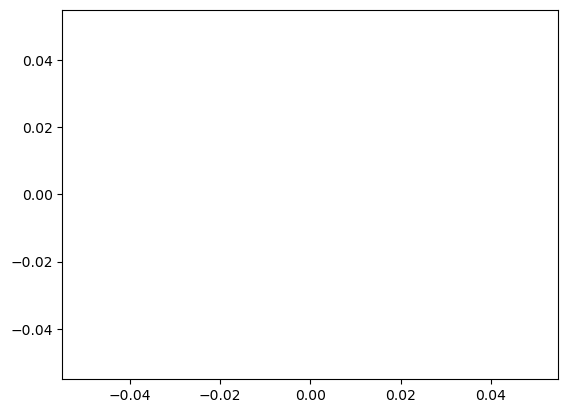

 78%|███████▊  | 56/72 [51:37<14:08, 53.05s/it]

Failed 0
0020_00970


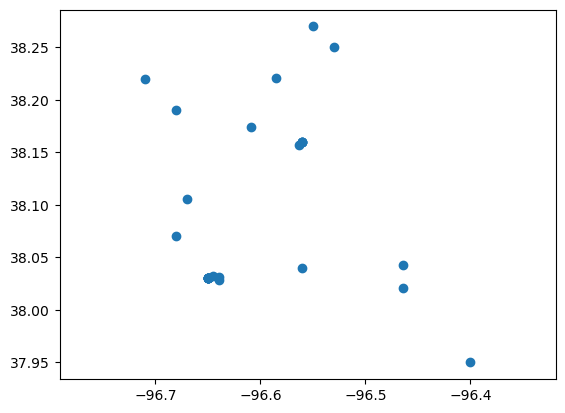

Sampler built with 95106 ignition points.
Scenario 0020_00276 has the wrong size for layout 0020_00970: 1124 != 499 or 1317 != 573


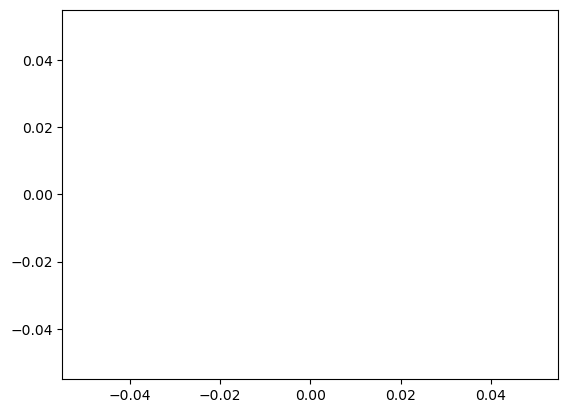

 79%|███████▉  | 57/72 [51:58<10:52, 43.50s/it]

Failed 0
0063_02387
Layout ./WideDataset/0063_02387/Satellite_Images_Mask/ does not exist


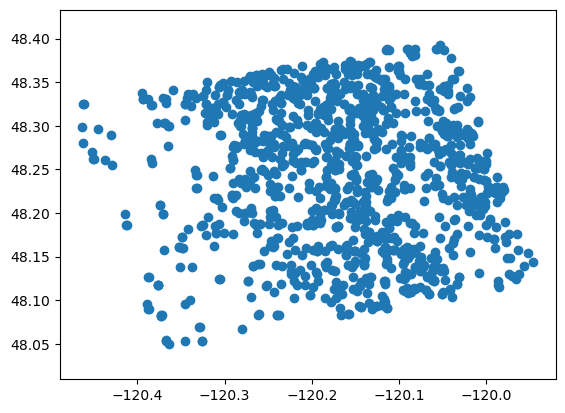

Sampler built with 64766 ignition points.


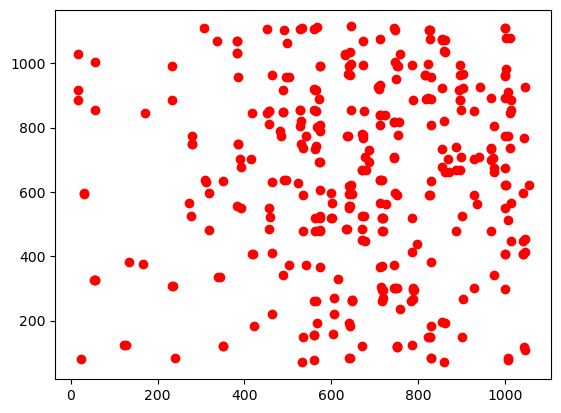

 81%|████████  | 58/72 [53:06<11:49, 50.71s/it]

Failed 887
!! Failed 887 out of 1232 for layout 0063_02387 !!
0061_03726
Layout ./WideDataset/0061_03726/Satellite_Images_Mask/ does not exist


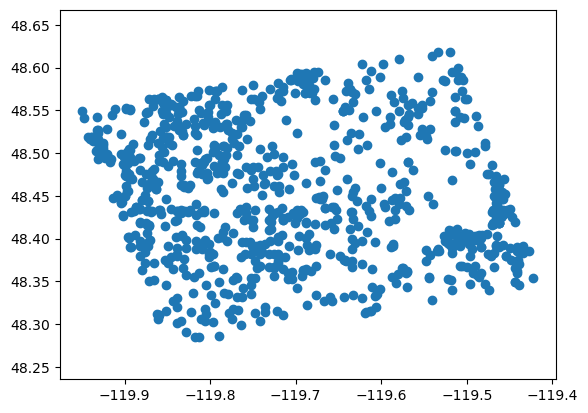

Sampler built with 64153 ignition points.


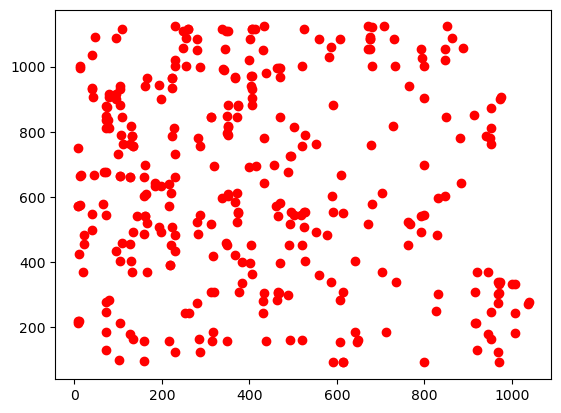

 82%|████████▏ | 59/72 [54:45<14:08, 65.27s/it]

Failed 593
!! Failed 593 out of 929 for layout 0061_03726 !!
0100_02449


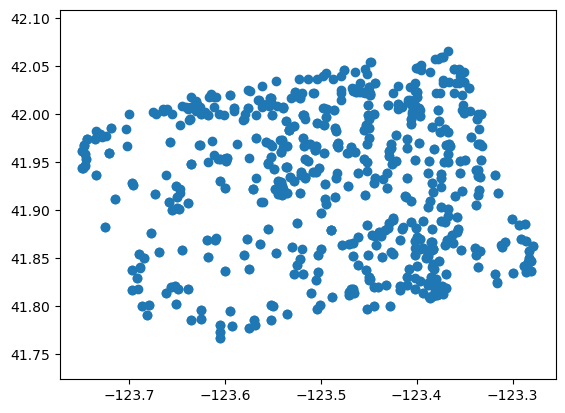

Sampler built with 36174 ignition points.
Scenario 0100_01361 has the wrong size for layout 0100_02449: 1163 != 572 or 945 != 471


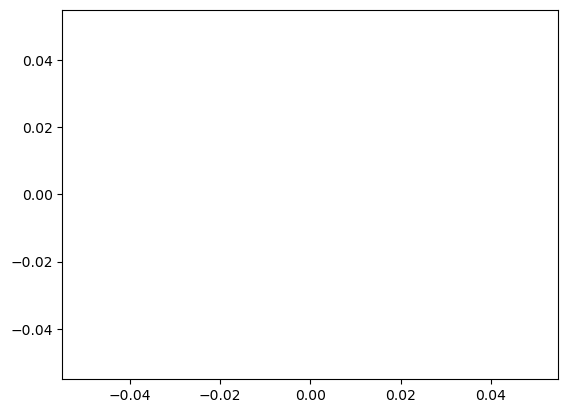

 83%|████████▎ | 60/72 [55:15<10:54, 54.55s/it]

Failed 0
0098_01784


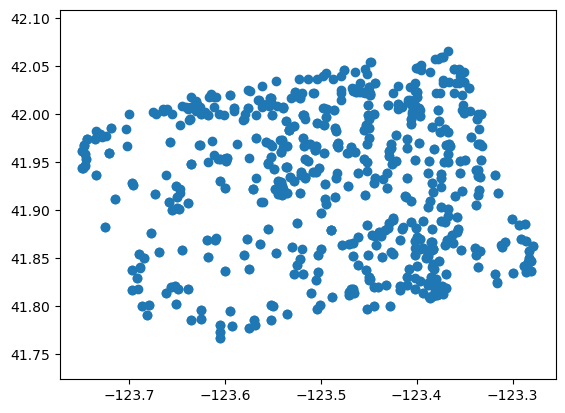

Sampler built with 32471 ignition points.
Scenario 0098_01539 has the wrong size for layout 0098_01784: 1163 != 520 or 945 != 487


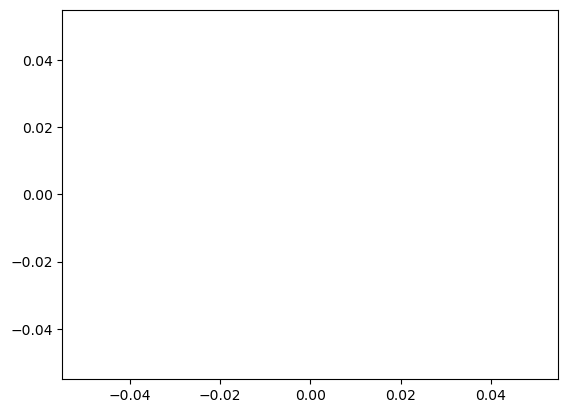

 85%|████████▍ | 61/72 [55:49<08:53, 48.54s/it]

Failed 0
0048_01141


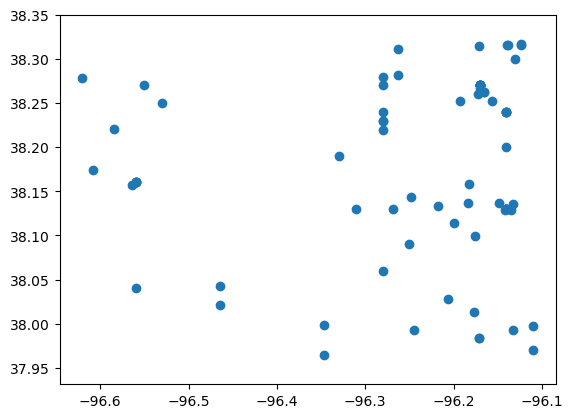

Sampler built with 55838 ignition points.


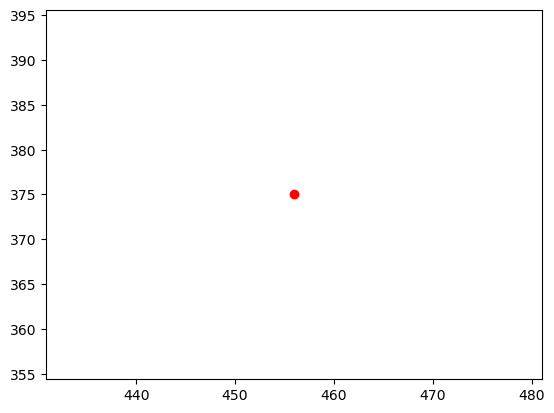

 86%|████████▌ | 62/72 [56:26<07:30, 45.00s/it]

Failed 76
!! Failed 76 out of 77 for layout 0048_01141 !!
0047_05424


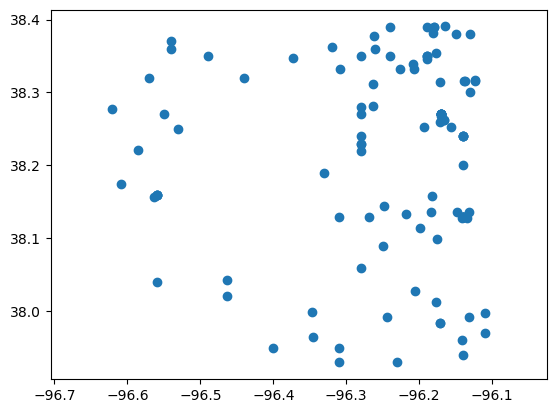

Sampler built with 260805 ignition points.


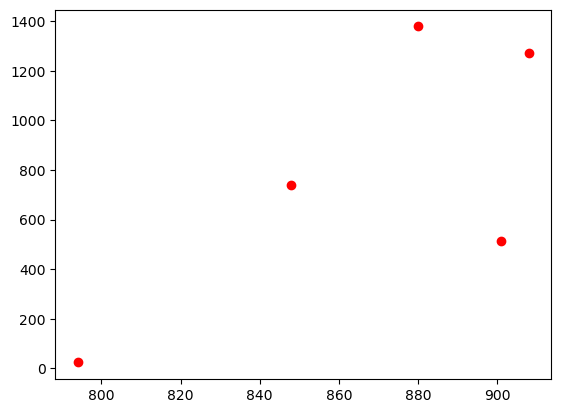

 88%|████████▊ | 63/72 [1:00:05<14:36, 97.34s/it]

Failed 106
!! Failed 106 out of 111 for layout 0047_05424 !!
0049_01289


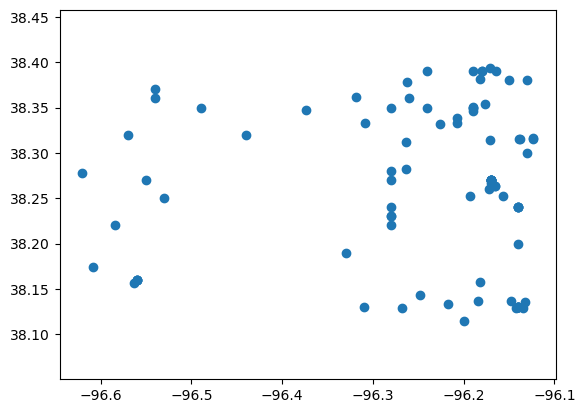

Sampler built with 56643 ignition points.


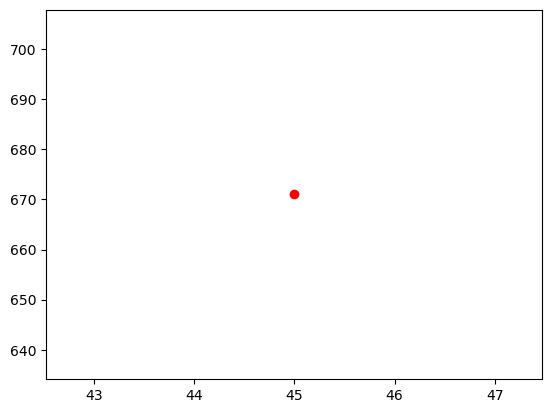

 89%|████████▉ | 64/72 [1:00:58<11:12, 84.01s/it]

Failed 89
!! Failed 89 out of 90 for layout 0049_01289 !!
0114_02292


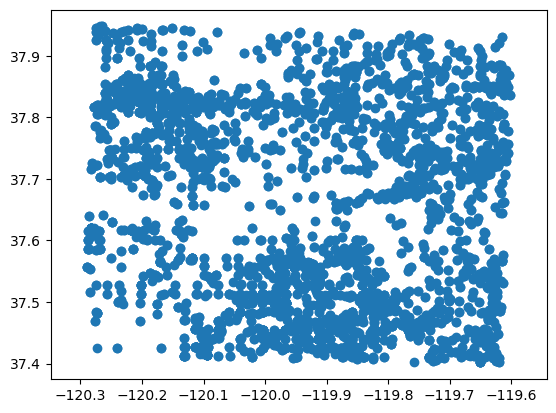

Sampler built with 68083 ignition points.
Scenario 0114_00559 has the wrong size for layout 0114_02292: 1995 != 671 or 1974 != 634


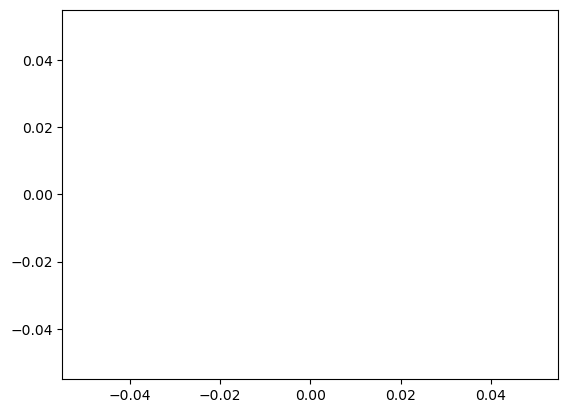

 90%|█████████ | 65/72 [1:01:49<08:38, 74.04s/it]

Failed 0
0113_03495


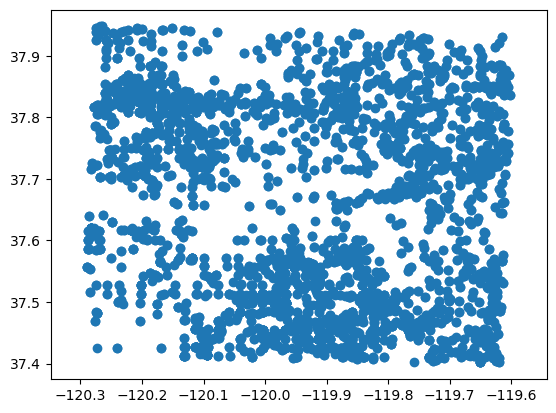

Error processing 0113_02657: No JPG files found in folder: ./WideDataset/0113_03495/Satellite_Images_Mask/0113_02657/
Error processing 0113_02658: No JPG files found in folder: ./WideDataset/0113_03495/Satellite_Images_Mask/0113_02658/
Sampler built with 54385 ignition points.
Scenario 0113_02882 has the wrong size for layout 0113_03495: 1995 != 857 or 1974 != 773


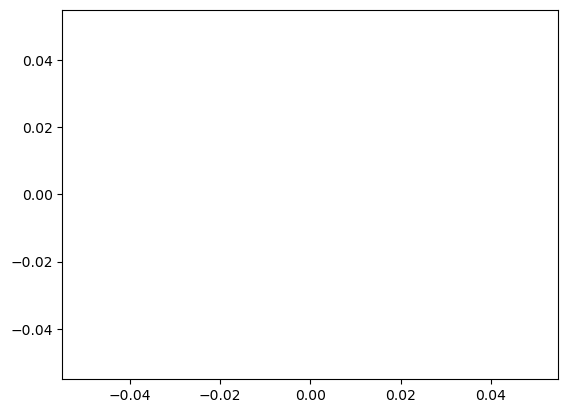

 92%|█████████▏| 66/72 [1:02:58<07:15, 72.50s/it]

Failed 0
0258_02858


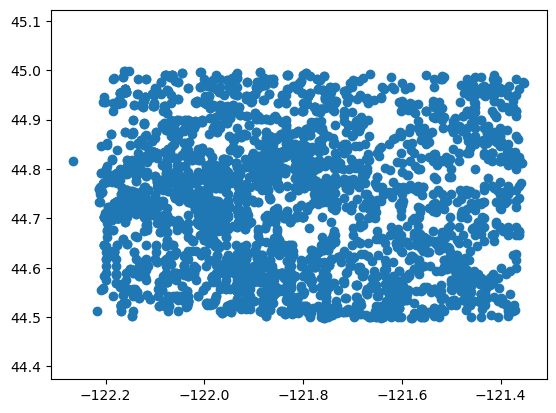

Sampler built with 55537 ignition points.
Scenario 0258_00492 has the wrong size for layout 0258_02858: 2263 != 1057 or 1840 != 960


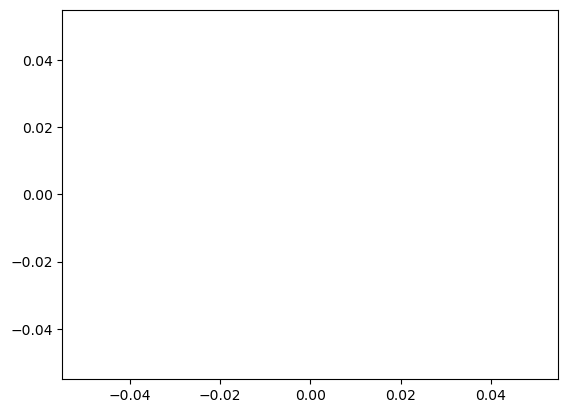

 93%|█████████▎| 67/72 [1:04:03<05:50, 70.19s/it]

Failed 0
0257_02175


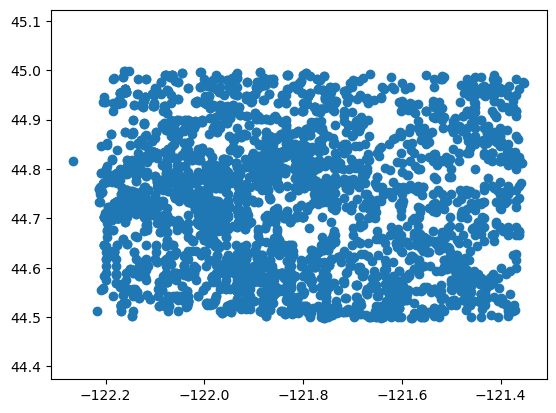

Sampler built with 25140 ignition points.
Scenario 0257_00180 has the wrong size for layout 0257_02175: 2263 != 1142 or 1840 != 1053


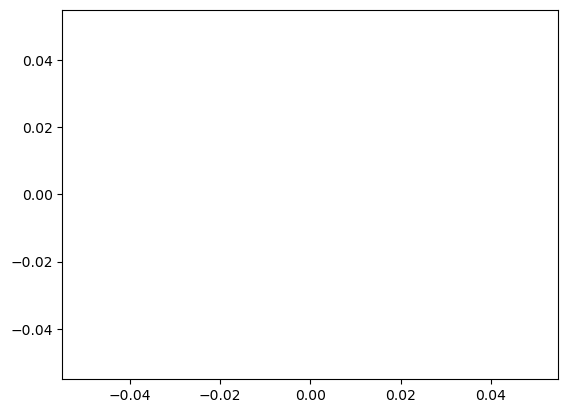

 94%|█████████▍| 68/72 [1:04:56<04:20, 65.17s/it]

Failed 0
0253_03246


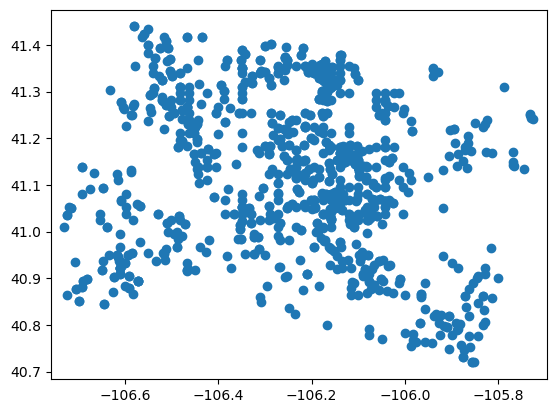

Sampler built with 56505 ignition points.
Scenario 0253_03222 has the wrong size for layout 0253_03246: 2712 != 812 or 2318 != 721


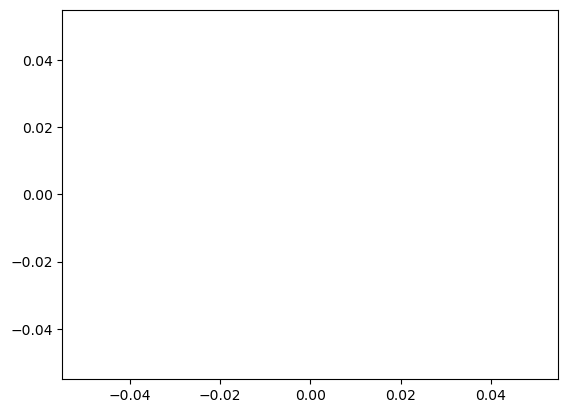

 96%|█████████▌| 69/72 [1:05:56<03:11, 63.69s/it]

Failed 0
0255_02103


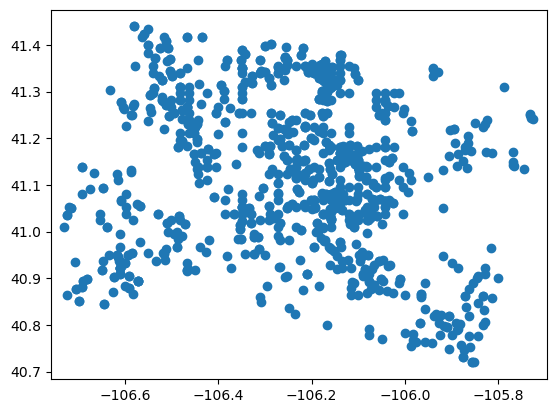

Sampler built with 30950 ignition points.
Scenario 0255_00574 has the wrong size for layout 0255_02103: 2712 != 632 or 2318 != 604


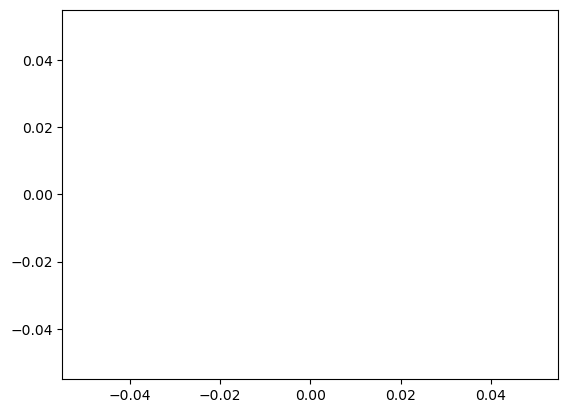

 97%|█████████▋| 70/72 [1:06:29<01:48, 54.45s/it]

Failed 0
0254_02361


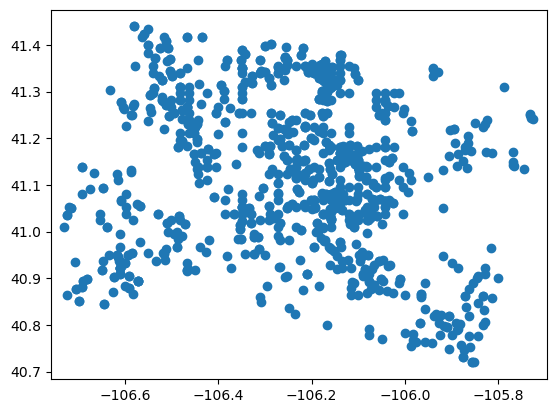

Sampler built with 31980 ignition points.
Scenario 0254_02140 has the wrong size for layout 0254_02361: 2712 != 710 or 2318 != 626


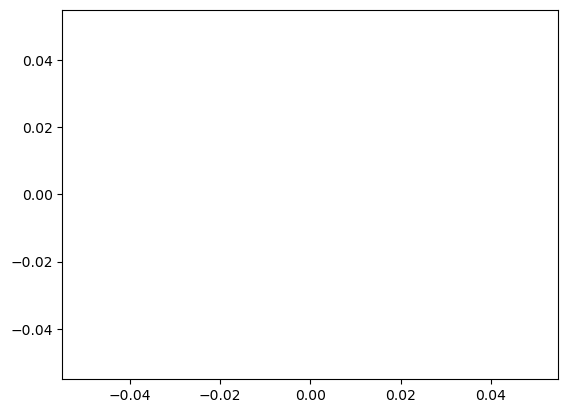

 99%|█████████▊| 71/72 [1:07:15<00:51, 51.76s/it]

Failed 0
0256_02752


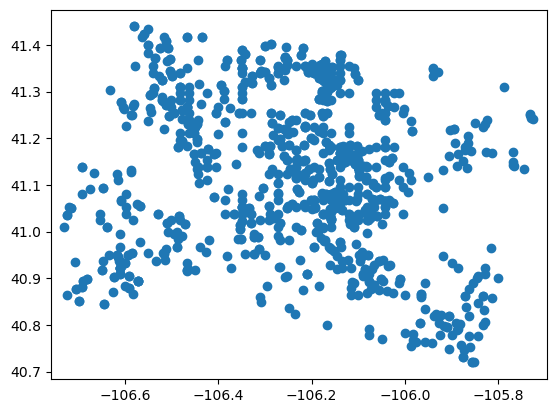

Sampler built with 44373 ignition points.
Scenario 0256_01331 has the wrong size for layout 0256_02752: 2712 != 720 or 2318 != 689


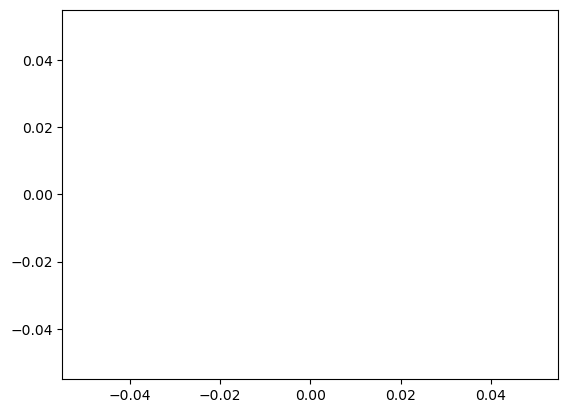

100%|██████████| 72/72 [1:07:58<00:00, 56.64s/it]

Failed 0
0
72


In [6]:
# Get the layout coordinates 
# 1 extract the tif files
dataset_path = "./WideDataset/"

# copy the layout tifs from a folder to a folder called sim2real_layout
tif_path = "sim2real_layouts"
os.makedirs(tif_path, exist_ok=True)
for folder in os.listdir(dataset_path):
    if folder == ".DS_Store":
        continue
    shutil.copy(f"WideDataset/{folder}/Vegetation_Map/Existing_Vegetation_Cover.tif", f"{tif_path}/{folder}_Existing_Vegetation_Cover.tif")

print("Copied the layout tifs to sim2real_layouts")
####

tif_files = glob(os.path.join(tif_path, "*.tif"))
layout_list = []
widths = []
names = []
for tif_file in tif_files:
    with rasterio.open(tif_file) as dataset:
        # get the file name without the path
        file_name = os.path.basename(tif_file)  # '0004_Elevation.tif'
        identifier = "_".join(file_name.split('_')[:2])

        # extract the resolution, check it is 30
        x_resolution = dataset.transform[0]
        y_resolution = -dataset.transform[4]
        assert x_resolution == y_resolution == 30, f"Resolution is not the same: {x_resolution} != {y_resolution}"

        # extract the coordinates using the bounds
        # /!\ DO NOT USE transform_bounds(dataset.crs, 'EPSG:4326', *dataset.bounds)
        x_min = dataset.bounds[0]
        x_max = dataset.bounds[2]
        y_min = dataset.bounds[1]
        y_max = dataset.bounds[3]

        transformer = Transformer.from_crs(dataset.crs, "EPSG:4326", always_xy=True)
        lat_top_left, lon_top_left = transformer.transform(x_min, y_max)
        lat_top_right, lon_top_right = transformer.transform(x_max, y_max)
        lat_bottom_left, lon_bottom_left = transformer.transform(x_min, y_min)
        lat_bottom_right, lon_bottom_right = transformer.transform(x_max, y_min)

        # Create the polygon using the transformed bounds
        polygon = Polygon((
            (lat_top_left, lon_top_left),
            (lat_top_right, lon_top_right),
            (lat_bottom_right, lon_bottom_right),
            (lat_bottom_left, lon_bottom_left),
            (lat_top_left, lon_top_left)  # close the polygon
        ))

        layout_list.append({
            'identifier': identifier,
            'height': dataset.height,
            'width': dataset.width,
            'geometry': polygon,
            'transformer': transformer,
            'dataset': dataset
        })


        widths.append(dataset.width)
        names.append(identifier)

sorted_indices = np.argsort(widths)
widths = np.array(widths)[sorted_indices]
names = np.array(names)[sorted_indices]
filtered_layout_list = [layout_list[i] for i in sorted_indices]

n_small_layouts = len(widths[widths < 500])
n_medium_layouts = len(widths[(widths >= 500) & (widths < 1000)])
n_large_layouts = len(widths[widths >= 1000])

small_layouts = filtered_layout_list[:n_small_layouts]
medium_layouts = filtered_layout_list[n_small_layouts:n_small_layouts + n_medium_layouts]
large_layouts = filtered_layout_list[n_small_layouts + n_medium_layouts:]

selected_layouts = medium_layouts + large_layouts
widths = widths[-len(selected_layouts):]
names = names[-len(selected_layouts):]


print("loaded the layout list")
# move the samll layouts to the small folder
os.makedirs("small_layouts", exist_ok=True)
for layout in small_layouts:
    #print(os.path.join(dataset_path, layout['identifier']), os.path.join("small_layouts", layout['identifier']))
    try:
        shutil.move(os.path.join(dataset_path, layout['identifier']), os.path.join("small_layouts", layout['identifier']))
    except Exception as e:
       # file already moved
       pass


# convert the layout list to a geopandas df
layout_list = selected_layouts
gdf = gpd.GeoDataFrame(layout_list, geometry='geometry', crs="EPSG:4326")




# Load the historical fires 
# fires_gdf = gpd.read_file("./FPA_FOD_20210617.gpkg")
# fires_gdf = fires_gdf.to_crs("EPSG:4326")
print("loaded the fires")


# Joint
# Spatial join: find which points fall into which polygons
joined = gpd.sjoin(fires_gdf, gdf, how='inner', predicate='within')


# Count points per polygon
counts = joined.groupby('identifier').size().reset_index(name='fire_count')


dataset_path = "./WideDataset/"
scenario_path_suffix = "/Satellite_Images_Mask/"

failed_layouts = []
continue_out = False
processed = total = 0

for layout_name in tqdm.tqdm(names):
    total+=1
    print(layout_name)
    try:
        layout_folder = dataset_path + layout_name + scenario_path_suffix
        # check the layout folder exists
        if not os.path.exists(layout_folder):
            print(f"Layout {layout_folder} does not exist")
            layout_folder = dataset_path + layout_name +  "/Satellite_Image_Mask/"
            if not os.path.exists(layout_folder):
                print(f"Layout {layout_folder} does not exist")
                failed_layouts.append(layout_name)
                continue
        
        if os.path.exists(f"./WideDataset/{layout_name}/selected_scenarios_full_match.txt"):
            processed +=1
            #continue

        # check that the scenario have the right size
        first_scenario = return_first_scenario(layout_folder)
        if first_scenario is None:
            print(f"Layout {layout_name} does not have any scenario")
            failed_layouts.append(layout_name)
            continue
        
        first_loaded_scenario = load_scenario(os.path.join(layout_folder, first_scenario), extension = '.jpg', first_frame_only=True)
        height_scenario, width_scenario = first_loaded_scenario.shape[0], first_loaded_scenario.shape[1]

        data = joined[joined['identifier'] == layout_name]
        if len(data) == 0:
            print(f"No fires found for layout {layout_name}")
            failed_layouts.append(layout_name)
            continue
        plt.scatter(data["LONGITUDE"], data["LATITUDE"])
        plt.axis("equal")
        plt.show()

        #earliest_date, latest_date = find_earliest_latest_dates(dataset_path + layout_name)
        #print(f"Earliest date: {earliest_date}, Latest date: {latest_date}")


        sampler = ScenarioSampler(layout_folder, extension = '.jpg')
        sampled_scenarios = []
        sampled_ignition_points = []
        associated_fires = []
        date_matched = []
        distances = []
        failed = 0
        # plot the historical fires
        

        # start with the fires that have potewntial to be test fires, i.e their date is between the earliest and latest date
        # We will have one "test" dataset, one "train" dataset, and one extra train dataset for the test fires
        # filtered_data = data[
        # (data['DISCOVERY_DATE'].dt.date >= earliest_date.date()) & 
        # (data['DISCOVERY_DATE'].dt.date <= latest_date.date())
        # ]
        

        for i, fire in data.iterrows():
            # print the coordinates of the fire
            width, height = fire['width'], fire['height']
            # check that the scenario have the right size
            if width != width_scenario or height != height_scenario:
                print(f"Scenario {first_scenario} has the wrong size for layout {layout_name}: {width} != {width_scenario} or {height} != {height_scenario}")
                failed_layouts.append(layout_name)
                break
            dataset = fire['dataset']
            transformer = fire['transformer']
            x_fire, y_fire = transformer.transform(fire['LONGITUDE'], fire['LATITUDE'], direction='INVERSE')
            row, col = rasterio.transform.rowcol(dataset.transform, x_fire, y_fire)
            # print("row, col", row, col)
            ignition_point = (col, row)
            sample, sampled_ignition_point = sampler.get_scenario_location(ignition_point, leeway_distance=5, sampling_method='closest', exclude_scenarios=sampled_scenarios)
            if sample is None:
                failed += 1
                continue
            sampled_scenarios.append(sample)
            sampled_ignition_points.append(sampled_ignition_point)
            associated_fires.append(fire['OBJECTID'])
            distance = abs(sampled_ignition_point[0] - ignition_point[0]) + abs(sampled_ignition_point[1] - ignition_point[1])
            distances.append(distance)
        # plot the sampled scenarios
        # the axes are inverted as coordinates start in (0,0) in the top left corner
        fig, ax = plt.subplots()
        ax.scatter([point[0] for point in sampled_ignition_points], [width - point[1] for point in sampled_ignition_points], color='red')
        plt.show()
        print(f"Failed {failed}")
        # write the selected scenarios in a txt file
        with open(f"./WideDataset/{layout_name}/selected_scenarios.txt", "w") as f:
            for scenario, fire_id in zip(sampled_scenarios, associated_fires):
                f.write(f"{scenario}, {fire_id}\n")
            f.write(f"Failed: {failed}\n")
            failed_percentage = failed / max(len(data),1)
            f.write(f"Failed percentage: {failed_percentage}\n")
        if len(data) == 0 or failed_percentage > 0.2:
            print(f"!! Failed {failed} out of {len(data)} for layout {layout_name} !!")
            failed_layouts.append(layout_name)
    except Exception as e:
        print(f"Error for layout {layout_name}: {e}")
        failed_layouts.append(layout_name)
print(processed)
print(total)
    

# TODO do we need to create the grid manually? I think the raster file will doirectly give you the coordinates within the layout


# for each fire, sample the scenario (space only, and time+space)
# write the identifier in a txt file (one for space only, one for time+space)

# move the scenarios into a selected folder
# "delete" the other scenarios

# train test split with the date












# same with date

In [ ]:
import geopandas as gpd

# # Path to your GeoJSON file
# geojson_file = './National_USFS_Fire_Occurrence_Point_(Feature_Layer).geojson'

# # Read the GeoJSON file
# gdf = gpd.read_file(geojson_file)

# # Path to the output GeoPackage file
# gpkg_file = 'newfires.gpkg'

# # Save the GeoDataFrame to a GeoPackage file
# gdf.to_file(gpkg_file, driver='GPKG')



KeyboardInterrupt



In [4]:
new_fires_gdf = gpd.read_file("./newfires.gpkg")

In [6]:
# remove all lines with DISCOVERYDATETIME = 1001/01/01 00:00:00+00
print(len(new_fires_gdf))
new_fires_gdf = new_fires_gdf[new_fires_gdf['DISCOVERYDATETIME'] != '1001/01/01 00:00:00+00']
print(len(new_fires_gdf))

582291
581759


In [7]:
new_fires_gdf['DISCOVERY_DATE'] = pd.to_datetime(new_fires_gdf['DISCOVERYDATETIME'])
new_fires_gdf['DISCOVERY_DATE'].dt.date


0         2014-07-03
1         2014-06-06
2         2014-07-28
3         2014-08-19
4         2014-08-26
             ...    
582286    2005-09-11
582287    2010-04-08
582288    2009-09-29
582289    1996-07-06
582290    2021-07-14
Name: DISCOVERY_DATE, Length: 581759, dtype: object

In [8]:
print(new_fires_gdf['geometry'].iloc[1])
print(new_fires_gdf['LATDD83'].iloc[1], new_fires_gdf['LONGDD83'].iloc[1])


POINT (-107.24360000079399 36.97472000088236)
36.97471 -107.24359


In [9]:
new_fires_gdf['DISCOVERY_DATE'] = pd.to_datetime(new_fires_gdf['DISCOVERYDATETIME'])
new_fires_gdf['DISCOVERY_DATE'].dt.date
new_fires_gdf['LONGITUDE'] = new_fires_gdf['LONGDD83']
new_fires_gdf['LATITUDE'] = new_fires_gdf['LATDD83']

In [10]:
# keep only the fires that occured after 2019
new_fires_gdf = new_fires_gdf[new_fires_gdf['DISCOVERY_DATE'] >= '2019-01-01']
print(len(new_fires_gdf))
new_fires_gdf['DISCOVERY_DATE'].head()


34889


24    2019-11-01 14:30:00+00:00
266   2019-07-25 15:37:00+00:00
267   2019-09-06 16:46:00+00:00
347   2022-04-20 21:56:00+00:00
348   2022-06-12 22:24:00+00:00
Name: DISCOVERY_DATE, dtype: datetime64[ns, UTC]

In [9]:
from Scenario_sampler import ScenarioSamplerDate
from tqdm import tqdm
# Get the layout coordinates 
# 1 extract the tif files
dataset_path = "./WideDataset/"

# copy the layout tifs from a folder to a folder called sim2real_layout
tif_path = "sim2real_layouts"
os.makedirs(tif_path, exist_ok=True)
for folder in os.listdir(dataset_path):
    if folder == ".DS_Store":
        continue
    shutil.copy(f"WideDataset/{folder}/Vegetation_Map/Existing_Vegetation_Cover.tif", f"{tif_path}/{folder}_Existing_Vegetation_Cover.tif")

print("Copied the layout tifs to sim2real_layouts")
####

tif_files = glob(os.path.join(tif_path, "*.tif"))
layout_list = []
widths = []
names = []
for tif_file in tif_files:
    with rasterio.open(tif_file) as dataset:
        # get the file name without the path
        file_name = os.path.basename(tif_file)  # '0004_Elevation.tif'
        identifier = "_".join(file_name.split('_')[:2])

        # extract the resolution, check it is 30
        x_resolution = dataset.transform[0]
        y_resolution = -dataset.transform[4]
        assert x_resolution == y_resolution == 30, f"Resolution is not the same: {x_resolution} != {y_resolution}"

        # extract the coordinates using the bounds
        # /!\ DO NOT USE transform_bounds(dataset.crs, 'EPSG:4326', *dataset.bounds)
        x_min = dataset.bounds[0]
        x_max = dataset.bounds[2]
        y_min = dataset.bounds[1]
        y_max = dataset.bounds[3]

        transformer = Transformer.from_crs(dataset.crs, "EPSG:4326", always_xy=True)
        lat_top_left, lon_top_left = transformer.transform(x_min, y_max)
        lat_top_right, lon_top_right = transformer.transform(x_max, y_max)
        lat_bottom_left, lon_bottom_left = transformer.transform(x_min, y_min)
        lat_bottom_right, lon_bottom_right = transformer.transform(x_max, y_min)

        # Create the polygon using the transformed bounds
        polygon = Polygon((
            (lat_top_left, lon_top_left),
            (lat_top_right, lon_top_right),
            (lat_bottom_right, lon_bottom_right),
            (lat_bottom_left, lon_bottom_left),
            (lat_top_left, lon_top_left)  # close the polygon
        ))

        layout_list.append({
            'identifier': identifier,
            'height': dataset.height,
            'width': dataset.width,
            'geometry': polygon,
            'transformer': transformer,
            'dataset': dataset
        })


        widths.append(dataset.width)
        names.append(identifier)

sorted_indices = np.argsort(widths)
widths = np.array(widths)[sorted_indices]
names = np.array(names)[sorted_indices]
filtered_layout_list = [layout_list[i] for i in sorted_indices]

n_small_layouts = len(widths[widths < 500])
n_medium_layouts = len(widths[(widths >= 500) & (widths < 1000)])
n_large_layouts = len(widths[widths >= 1000])

small_layouts = filtered_layout_list[:n_small_layouts]
medium_layouts = filtered_layout_list[n_small_layouts:n_small_layouts + n_medium_layouts]
large_layouts = filtered_layout_list[n_small_layouts + n_medium_layouts:]

print("loaded the layout list")


# convert the layout list to a geopandas df
gdf = gpd.GeoDataFrame(layout_list, geometry='geometry', crs="EPSG:4326")




# Load the historical fires 
# fires_gdf = gpd.read_file("./FPA_FOD_20210617.gpkg")
# fires_gdf = fires_gdf.to_crs("EPSG:4326")
print("loaded the fires")


# Joint
# Spatial join: find which points fall into which polygons
joined = gpd.sjoin(new_fires_gdf, gdf, how='inner', predicate='within')


# Count points per polygon
counts = joined.groupby('identifier').size().reset_index(name='fire_count')
print(counts)


dataset_path = "./WideDataset/"
scenario_path_suffix = "/Satellite_Images_Mask/"

failed_layouts = []
processed_layouts = []
continue_out = False
processed = total = 0
WORKED = 0

for layout_name in tqdm(names):
    total+=1
    #print(layout_name)
    try:
        layout_folder = dataset_path + layout_name + scenario_path_suffix
        # check the layout folder exists
        if not os.path.exists(layout_folder):
            print(f"Layout {layout_folder} does not exist")
            layout_folder = dataset_path + layout_name +  "/Satellite_Image_Mask/"
            if not os.path.exists(layout_folder):
                print(f"Layout {layout_folder} does not exist")
                failed_layouts.append(layout_name)
                continue
        
        if os.path.exists(f"./WideDataset/{layout_name}/selected_scenarios.txt"):
            processed +=1
            #continue

        # check that the scenario have the right size
        first_scenario = return_first_scenario(layout_folder)
        if first_scenario is None:
            print(f"Layout {layout_name} does not have any scenario")
            failed_layouts.append(layout_name)
            continue
        
        first_loaded_scenario = load_scenario(os.path.join(layout_folder, first_scenario), extension = '.jpg', first_frame_only=True)
        height_scenario, width_scenario = first_loaded_scenario.shape[0], first_loaded_scenario.shape[1]

        earliest_date, latest_date = find_earliest_latest_dates(dataset_path + layout_name)

        # if earliest_date.year > 2020:
        #     print(f"Layout {layout_name} has no fires before 2021: {earliest_date}")
        #     failed_layouts.append(layout_name)
        #     continue

        # plot the historical fires
        data = joined[joined['identifier'] == layout_name]

        filtered_data = data[
        (data['DISCOVERY_DATE'].dt.date >= earliest_date.date()) & 
        (data['DISCOVERY_DATE'].dt.date <= latest_date.date())
        ]
        n_data = len(filtered_data)
        if n_data == 0:
            #print(f"No fires found for layout {layout_name} between {earliest_date} and {latest_date}")
            # if len(data) != 0:  
            #     print("example  fire date:", data['DISCOVERY_DATE'].iloc[0])
            failed_layouts.append(layout_name)
            continue


        sampler = ScenarioSamplerDate(layout_folder, extension = '.jpg')
        sampled_scenarios = []
        sampled_ignition_points = []
        sampled_ignition_dates = []
        associated_fires = []
        date_matched = []
        distances = []
        failed = 0
        

        #plt.scatter(filtered_data["LONGITUDE"], filtered_data["LATITUDE"])
        #plt.axis("equal")
        #plt.show()

        # start with the fires that have potewntial to be test fires, i.e their date is between the earliest and latest date
        # We will have one "test" dataset, one "train" dataset, and one extra train dataset for the test fires

        

        for i, fire in filtered_data.iterrows():
            # print the coordinates of the fire
            width, height = fire['width'], fire['height']
            # check that the scenario have the right size
            if width != width_scenario or height != height_scenario:
                print(f"Scenario {first_scenario} has the wrong size for layout {layout_name}: {width} != {width_scenario} or {height} != {height_scenario}")
                failed_layouts.append(layout_name)
                n_data = 0 
                break
            dataset = fire['dataset']
            transformer = fire['transformer']
            x_fire, y_fire = transformer.transform(fire['LONGITUDE'], fire['LATITUDE'], direction='INVERSE')
            row, col = rasterio.transform.rowcol(dataset.transform, x_fire, y_fire)
            date = fire['DISCOVERY_DATE']
            # print("row, col", row, col)
            ignition_point = (row, col)
            res = sampler.get_scenario_location(ignition_point, date = fire['DISCOVERY_DATE'].date(), leeway_distance=10, leeway_date=1, sampling_method='closest', exclude_scenarios=sampled_scenarios)
            if res[0] is None:
                sample, sampled_ignition_point, sampled_ignition_date = None, None, None
            else:
                sample, sampled_ignition_point, sampled_ignition_date = res
            if sample is None:
                failed += 1
                print("we wanted to sample the fire", fire['DISCOVERY_DATE'], "at", ignition_point, "but it failed")
                #print(sampler.get_all_scenario_dates())
                #print(sampler.get_all_scenario_ignition_points())
                #print("-- surprising? --")
                #print(sampler.get_scenarios_at_a_date(fire['DISCOVERY_DATE'].date()))
                continue
            else:
                print(sample)
            sampled_scenarios.append(sample)
            sampled_ignition_points.append(sampled_ignition_point)
            sampled_ignition_dates.append(sampled_ignition_date)
            associated_fires.append(fire['OBJECTID'])
            distance = abs(sampled_ignition_point[0] - ignition_point[0]) + abs(sampled_ignition_point[1] - ignition_point[1])
            distances.append(distance)
        # plot the sampled scenarios
        # the axes are inverted as coordinates start in (0,0) in the top left corner
        #fig, ax = plt.subplots()
        #ax.scatter([point[0] for point in sampled_ignition_points], [width - point[1] for point in sampled_ignition_points], color='red')
        #plt.show()
        #print(f"Failed {failed}")
        # write the selected scenarios in a txt file
        with open(f"./WideDataset/{layout_name}/selected_scenarios_historical.txt", "w") as f:
            for scenario, fire_id in zip(sampled_scenarios, associated_fires):
                f.write(f"{scenario}, {fire_id}\n")
            f.write(f"Failed: {failed}\n")
            failed_percentage = failed / max(n_data,1)
            f.write(f"Failed percentage: {failed_percentage}\n")
            #print(f"Layout {layout_name}: {n_data} fires, {failed} failed, {failed_percentage}")
            processed_layouts.append(layout_name)
        if n_data != 0 and failed != n_data:
            WORKED += 1
            print(f"WORKED: {WORKED}, {sampled_scenarios}")
            print("worked: ", layout_name)
            plt.scatter(filtered_data["LONGITUDE"], filtered_data["LATITUDE"])
            plt.axis("equal")
            plt.show()
            fig, ax = plt.subplots()
            ax.scatter([point[0] for point in sampled_ignition_points], [width - point[1] for point in sampled_ignition_points], color='red')
            plt.show()
        if n_data != 0 and failed_percentage > 0.2:
            print(f"!! Failed {failed} out of {n_data} for layout {layout_name} !!")
            failed_layouts.append(layout_name)
    except Exception as e:
        print(f"Error for layout {layout_name}: {e}")
        failed_layouts.append(layout_name)
print(processed)
print(total)
print(processed_layouts)
    

# TODO do we need to create the grid manually? I think the raster file will doirectly give you the coordinates within the layout


# for each fire, sample the scenario (space only, and time+space)
# write the identifier in a txt file (one for space only, one for time+space)

# move the scenarios into a selected folder
# "delete" the other scenarios

# train test split with the date









Copied the layout tifs to sim2real_layouts
loaded the layout list
loaded the fires
    identifier  fire_count
0   0016_03070         192
1   0037_01578          21
2   0041_02386          66
3   0057_03186         279
4   0058_03866         183
5   0059_02804         264
6   0060_03010         381
7   0061_03726         328
8   0062_03187          55
9   0063_02387         896
10  0064_02717         172
11  0065_03061         116
12  0066_03773         174
13  0067_03550         280
14  0068_04211         142
15  0069_03539         629
16  0081_03471         252
17  0082_03155         691
18  0083_02892        1098
19  0084_02609         249
20  0090_00987         537
21  0092_03189          26
22  0093_01748           1
23  0094_01688           1
24  0095_01726           1
25  0098_01784         544
26  0100_02449         544
27  0102_01733         714
28  0103_01810         714
29  0104_02422         180
30  0105_03054         142
31  0106_02165          43
32  0111_03612          59

  7%|▋         | 5/72 [00:00<00:01, 35.65it/s]

Error for layout 0344_03155: No subfolder found
Layout ./WideDataset/0106_02165/Satellite_Images_Mask/ does not exist
Layout ./WideDataset/0111_03612/Satellite_Images_Mask/ does not exist


 12%|█▎        | 9/72 [00:00<00:02, 22.97it/s]

Layout ./WideDataset/0104_02422/Satellite_Images_Mask/ does not exist
Error for layout 0089_00984: No subfolder found
we wanted to sample the fire 2023-07-24 23:34:00+00:00 at (396, 62) but it failed
we wanted to sample the fire 2023-07-24 23:34:00+00:00 at (396, 62) but it failed
!! Failed 2 out of 2 for layout 0016_03070 !!


 17%|█▋        | 12/72 [00:02<00:14,  4.13it/s]

Layout ./WideDataset/0105_03054/Satellite_Images_Mask/ does not exist


 19%|█▉        | 14/72 [00:02<00:11,  4.84it/s]

Error for layout 0259_02663: unconverted data remains:  


 31%|███       | 22/72 [00:02<00:05,  9.15it/s]

Layout ./WideDataset/0243_02722/Satellite_Images_Mask/ does not exist
Error for layout 0013_01466: No subfolder found
Error for layout 0012_02094: No subfolder found


 44%|████▍     | 32/72 [00:03<00:04,  9.61it/s]

Error for layout 0065_03061: unconverted data remains:  0
Layout ./WideDataset/0064_02717/Satellite_Images_Mask/ does not exist


 47%|████▋     | 34/72 [00:04<00:05,  7.40it/s]

Layout ./WideDataset/0059_02804/Satellite_Images_Mask/ does not exist


 49%|████▊     | 35/72 [00:04<00:05,  6.72it/s]

Error for layout 0103_01810: No subfolder found
Error for layout 0102_01733: No subfolder found


 57%|█████▋    | 41/72 [00:05<00:04,  7.73it/s]

Error for layout 0261_02900: unconverted data remains:  
Error for layout 0057_03186: unconverted data remains:  
Error for layout 0090_00987: No subfolder found
Layout ./WideDataset/0242_02940/Satellite_Images_Mask/ does not exist


 62%|██████▎   | 45/72 [00:05<00:02, 11.76it/s]

Error for layout 0245_03988: No JPG files found in folder: ./WideDataset/0245_03988/Satellite_Images_Mask/0245_03900/
Error for layout 0081_03471: unconverted data remains:  0
Layout ./WideDataset/0060_03010/Satellite_Images_Mask/ does not exist


 65%|██████▌   | 47/72 [00:05<00:02,  8.85it/s]

Error for layout 0060_03010: unconverted data remains:  
Layout ./WideDataset/0062_03187/Satellite_Images_Mask/ does not exist
Error for layout 0062_03187: unconverted data remains:  


 68%|██████▊   | 49/72 [00:05<00:02,  7.87it/s]

Error for layout 0262_03319: unconverted data remains:  
Layout ./WideDataset/0058_03866/Satellite_Images_Mask/ does not exist


 69%|██████▉   | 50/72 [00:06<00:02,  7.69it/s]

Layout ./WideDataset/0244_03110/Satellite_Images_Mask/ does not exist


 71%|███████   | 51/72 [00:06<00:03,  5.33it/s]

Error for layout 0244_03110: unconverted data remains:  
Error for layout 0093_01748: No subfolder found
Error for layout 0095_01726: No subfolder found
Error for layout 0094_01688: No subfolder found


 76%|███████▋  | 55/72 [00:06<00:02,  7.30it/s]

Error for layout 0083_02892: unconverted data remains:  
Error for layout 0021_01232: No subfolder found
Error for layout 0020_00970: No subfolder found
Layout ./WideDataset/0063_02387/Satellite_Images_Mask/ does not exist


 81%|████████  | 58/72 [00:07<00:01,  8.34it/s]

Error for layout 0063_02387: unconverted data remains:  
Layout ./WideDataset/0061_03726/Satellite_Images_Mask/ does not exist


100%|██████████| 72/72 [00:07<00:00,  9.54it/s]

Error for layout 0098_01784: No subfolder found
Error for layout 0100_02449: No subfolder found
Error for layout 0113_03495: No subfolder found
Error for layout 0114_02292: No subfolder found
Error for layout 0257_02175: No subfolder found
Error for layout 0258_02858: No subfolder found
Error for layout 0255_02103: No subfolder found
Error for layout 0254_02361: No subfolder found
Error for layout 0256_02752: No subfolder found
Error for layout 0253_03246: No subfolder found
71
72
['0016_03070']


In [28]:
print(len(new_fires_gdf['OBJECTID'].unique()))
print(len(new_fires_gdf))

581759
581759
